In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction/test.csv
/kaggle/input/auto-ru-29-11-2020csv/auto_ru_29_11_2020.csv


In [2]:
#импорт модулей
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math
import regex as re

from sklearn.feature_selection import f_classif
from itertools import combinations
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

RANDOM_SEED=42

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

In [3]:
pd.set_option('display.max_columns', None)

# Загрузка тестовых данных

In [4]:
PATH_to_file = '/kaggle/input/sf-dst-car-price/'

In [5]:
test = pd.read_csv('/kaggle/input/sf-dst-car-price-prediction/test.csv')

Определим список имеющихся параметров, соответственно список интересующих нас при поиске)

In [6]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

Определим список необходимых брендов. Это конечно не обязательно т.к. дополнительные бренды дадут больше данных и больше возможностей для выявления зависимостей, но увеличит времясбора данных

In [7]:
test.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [8]:
test.sell_id

0        1100575026
1        1100549428
2        1100658222
3        1100937408
4        1101037972
            ...    
34681    1101369263
34682    1101369581
34683    1101364889
34684    1101362518
34685    1101256068
Name: sell_id, Length: 34686, dtype: int64

In [9]:
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [10]:
test.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

Определились с необходимой информацией для выгрузки. Так же сделаем определенные выводы о имеющихся данных


car_url - не нужен при обработке, можно удалить. Хотя , конечно, можно выгрузить но это не спортивно.

image - адрес картинки тоже не нужен

priceCurrency - если везде в рублях то можно удалить)



In [11]:
train=pd.read_csv('/kaggle/input/auto-ru-29-11-2020csv/auto_ru_29_11_2020.csv')

In [12]:
train.head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,CACECB,бензин,1982.0,1.8 MT (90 л.с.),4.0,1984,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,300000,{'id': '0'},передний,LEFT,NaN,2.0,ORIGINAL,True,NaN,100000.0,2020-11-29T13:46:39Z,NaN,100
1,Седан,AUDI,0000CC,бензин,1988.0,2.0 MT (115 л.с.),4.0,1989,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,115.0,"Рассмотрю обмен.Машина в достойном состоянии,н...",150000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,90000.0,2020-11-15T10:23:16Z,NaN,100


In [13]:
train.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')

In [14]:
print('размерность собранного датасета:' ,train.shape)
print('размерность тестового датасета:' ,test.shape)

размерность собранного датасета: (71336, 26)
размерность тестового датасета: (34686, 32)


Как видим размерности отличаются, более того надо проверить содержимое датасетов(значений в столбцах) для адекватности слияния

#  Объединение данных

In [15]:
# напишем функции по сравнению наших датасетов
def df_compare(first_df,second_df):    
    
    names_first = list(first_df.columns)
    temp_dict = {}
    temp_dict['имя признака first'] = names_first
    temp_dict['тип first'] = first_df.dtypes
    temp_dict['unique vals first'] = first_df.nunique().values
    temp_dict['в первой строке first'] =first_df.loc[0].values#вот это я сначала забыл , подсказали
                                                                #идее тут надо возвращать любое не пустое значение но с наскока не получилось, отложил
    
    temp_df_first = pd.DataFrame.from_dict(temp_dict)
    
    
    names_second = list(second_df.columns)
    temp_dict2 = {}
    temp_dict2['имя признака second'] = names_second
    temp_dict2['тип second'] = second_df.dtypes
    temp_dict2['unique vals second'] = second_df.nunique().values
    temp_dict2['в первой строке second'] =second_df.loc[0].values
    temp_df_second = pd.DataFrame.from_dict(temp_dict2)
    
    temp_df = pd.concat([temp_df_first,temp_df_second], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    return temp_df

def analise_comparing_type(temp_df):    
    #фреймм получится большой надо сразу сделать анализ
    #vметод "пристального взгляда" может дать осечку
    dict_type = {}
    temp_df3= pd.DataFrame(temp_df)
    list_type_1  = []
    list_type_2  = []
    list_type_3  = []
    list_type_4  = []
    list_type_5  = []

    for i in range(len(temp_df)):
        if str(temp_df['тип first'][i]) != str(temp_df['тип second'][i]):
            list_type_1.append(temp_df['имя признака first'][i])
            list_type_2.append(temp_df['имя признака second'][i])
            list_type_3.append(str(temp_df['тип first'][i]) + '!=' + str(temp_df['тип second'][i]))
            list_type_4.append(i)
            
    dict_type['index']= list_type_4
    dict_type['имя признака first']= list_type_1
    dict_type['не совпадают типы'] = list_type_3
    dict_type['имя признака second']= list_type_2        
    
    temp_df3 = pd.DataFrame.from_dict(dict_type)
    temp_df3.set_index('index',inplace=True)
    display(temp_df3)
    
def analise_comparing_unique(temp_df):  
    dict_uniq = {}
    list_uniq_1  = []
    list_uniq_2  = []
    list_uniq_3  = []
    list_uniq_4  = []
    for i in range(len(temp_df)):
        if temp_df['unique vals first'][i] != temp_df['unique vals second'][i]:
            list_uniq_1.append(temp_df['имя признака first'][i])
            list_uniq_2.append(temp_df['имя признака second'][i])
            list_uniq_3.append(str(temp_df['unique vals first'][i]) + '!=' + str(temp_df['unique vals second'][i]))
            list_uniq_4.append(i)
            
    dict_uniq['index']= list_uniq_4
    dict_uniq['имя признака first']= list_uniq_1
    dict_uniq['не совпадают уник значения'] = list_uniq_3
    dict_uniq['имя признака second']= list_uniq_2 
    temp_df4 = pd.DataFrame.from_dict(dict_uniq)
    temp_df4.set_index('index',inplace=True)
    display(temp_df4)


In [16]:
compare=df_compare(test,train)
display(compare)

,имя признака first,тип first,unique vals first,в первой строке first,имя признака second,тип second,unique vals second,в первой строке second
0,bodyType,object,24.0,лифтбек,bodyType,object,167.0,Седан
1,brand,object,12.0,SKODA,brand,object,36.0,AUDI
2,car_url,object,34686.0,https://auto.ru/cars/used/sale/skoda/octavia/1...,NaN,NaN,NaN,NaN
3,color,object,16.0,синий,color,object,16.0,CACECB
4,complectation_dict,object,2364.0,NaN,NaN,NaN,NaN,NaN
5,description,object,31732.0,"Все автомобили, представленные в продаже, прох...",description,object,57550.0,NaN
6,engineDisplacement,object,55.0,1.2 LTR,engineDisplacement,object,498.0,1.8
7,enginePower,object,315.0,105 N12,enginePower,float64,384.0,90
8,equipment_dict,object,23705.0,"{""engine-proof"":true,""tinted-glass"":true,""airb...",NaN,NaN,NaN,NaN
9,fuelType,object,5.0,бензин,fuelType,object,7.0,бензин


In [17]:
analise_comparing_type(df_compare(test,train))

,имя признака first,не совпадают типы,имя признака second
index,,,
2,car_url,object!=nan,NaN
4,complectation_dict,object!=nan,NaN
7,enginePower,object!=float64,enginePower
8,equipment_dict,object!=nan,NaN
10,image,object!=nan,NaN
12,modelDate,int64!=float64,modelDate
13,model_info,object!=nan,NaN
14,model_name,object!=nan,NaN
16,numberOfDoors,int64!=float64,numberOfDoors


помним что fist-тестовый
second - учебный

'car_url','image','priceCurrency','vendor','model_info','sell_id' по факту не нужны либо зашифрованы другими параметрами.

complectation_dict=Комплектация

Таможня привести к True,False




In [18]:
#test = test.rename(columns={'sell_id': 'id'})

In [19]:
test=test.drop(['car_url','image','priceCurrency','model_info'],axis='columns')
train['vendor']='O'

In [20]:
train = train.rename(columns={'Комплектация': 'complectation_dict','model':'model_name'})

In [21]:
train=train.drop(['hidden'],axis='columns')

In [22]:
test['price']=0

In [23]:
test.parsing_unixtime.head()

0    1603226273
1    1603226277
2    1603226280
3    1603226284
4    1603226288
Name: parsing_unixtime, dtype: int64

In [24]:
test['start_date']=test.parsing_unixtime.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))
test['start_date']=test.start_date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
test=test.drop(['parsing_unixtime'],axis='columns')
test['start_date']


0       2020-10-20
1       2020-10-20
2       2020-10-20
3       2020-10-20
4       2020-10-20
           ...    
34681   2020-10-26
34682   2020-10-26
34683   2020-10-26
34684   2020-10-26
34685   2020-10-26
Name: start_date, Length: 34686, dtype: datetime64[ns]

In [25]:
train['start_date']=train.start_date.apply(lambda x: datetime.strptime(str(x)[0:10], '%Y-%m-%d'))
train['start_date']

0       2020-11-29
1       2020-11-15
2       2020-11-28
3       2020-11-28
4       2020-11-08
           ...    
71331   2020-11-03
71332   2020-09-17
71333   2020-10-20
71334   2019-05-14
71335   2020-09-10
Name: start_date, Length: 71336, dtype: datetime64[ns]

с чем легко разобраться простым переводом и мучиться не нужнно с проверками

modelDate,numberOfDoors

In [26]:
cols = ['productionDate', 'price','numberOfDoors','modelDate']
for col in cols:
        test[col] = test[col].astype('float64')

In [27]:
test['productionDate']=test['productionDate'].astype('int64')

In [28]:
test['Таможня']=test['Таможня'].apply(lambda x: True if x=='Растаможен' else False)

In [29]:
#df_train['Владельцы'] = df_train['Владельцы'].map({3.0:'3 или более', 2.0:'2\xa0владельца', 1.0:'1\xa0владелец'})
test.Владельцы.value_counts()

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

In [30]:
train=train.rename(columns={'Владельцы':'owners'})
train.owners.value_counts()

3.0    25310
1.0    16403
2.0    15354
Name: owners, dtype: int64

In [31]:
test['Владельцы']=test['Владельцы'].apply(lambda x: 3 if '3' in str(x) else (2 if '2' in str(x) else 1))
test=test.rename(columns={'Владельцы':'owners'})
test['owners']=test['owners'].astype('float64')
test.owners.value_counts()

3.0    15957
1.0     9459
2.0     9270
Name: owners, dtype: int64

In [32]:
test['enginePower']=test['enginePower'].apply(lambda x: int(x.split()[0]))
test['enginePower']=test['enginePower'].fillna(0)
test['enginePower']=test['enginePower'].astype('int64',errors='ignore')
train['enginePower']=train['enginePower'].fillna(0)
train['enginePower']=train['enginePower'].astype('int64')

In [33]:
test['engineDisplacement']=test['engineDisplacement'].apply(lambda x: str(x).split(' ')[0])

In [34]:
test = test.drop(['equipment_dict'],axis='columns')

In [35]:
train['Состояние']=train['Состояние'].astype('object')

In [36]:
test.super_gen[0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

In [37]:
test = test.drop(['super_gen'],axis='columns')

In [38]:
analise_comparing_type(df_compare(test,train))

,имя признака first,не совпадают типы,имя признака second
index,,,
14,sell_id,int64!=nan,NaN


In [39]:
print('размерность собранного датасета:' ,train.shape)
print('размерность тестового датасета:' ,test.shape)

размерность собранного датасета: (71336, 26)
размерность тестового датасета: (34686, 27)


Отличаются только по id

In [40]:
colors = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий','CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 'FFC0CB':'розовый'}
train['color'] = train['color'].map(colors)

In [41]:
train['bodyType'] = train['bodyType'].apply(lambda x: str(x).lower())
test['bodyType'] = test['bodyType'].apply(lambda x: str(x).lower())

In [42]:
transmission={'MECHANICAL':'механическая', 'AUTOMATIC':'автоматическая', 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'}
train['vehicleTransmission'] = train['vehicleTransmission'].map(transmission)

In [43]:
wheel={'RIGHT':'Правый', 'LEFT':'Левый'}
train['Руль'] = train['Руль'].map(wheel)

In [44]:
PTS={'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'}
train['ПТС'] = train['ПТС'].map(PTS)

In [45]:
analise_comparing_unique(df_compare(test,train))

,имя признака first,не совпадают уник значения,имя признака second
index,,,
0,bodyType,24!=167.0,bodyType
1,brand,12!=36.0,brand
3,complectation_dict,2364!=5006.0,complectation_dict
4,description,31732!=57550.0,description
5,engineDisplacement,55!=498.0,engineDisplacement
6,enginePower,315!=385.0,enginePower
7,fuelType,5!=7.0,fuelType
8,mileage,11268!=17730.0,mileage
9,modelDate,66!=74.0,modelDate


In [46]:
print('тестовый датасет')
display(test.head(2))
print('тренировочный датасет')
display(train.head(2))

тестовый датасет


,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,vendor,owners,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,start_date
0,лифтбек,SKODA,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2,105,бензин,74000,2013.0,OCTAVIA,1.2 AMT (105 л.с.),5.0,2014,1100575026,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3.0,NaN,Оригинал,передний,Левый,Не требует ремонта,True,0.0,2020-10-20
1,лифтбек,SKODA,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110,бензин,60563,2017.0,OCTAVIA,1.6 MT (110 л.с.),5.0,2017,1100549428,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1.0,NaN,Оригинал,передний,Левый,Не требует ремонта,True,0.0,2020-10-20


тренировочный датасет


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,vendor
0,седан,AUDI,серебристый,бензин,1982.0,1.8 MT (90 л.с.),4.0,1984,SEDAN MECHANICAL 1.8,механическая,1.8,90,NaN,300000,{'id': '0'},передний,Левый,NaN,2.0,Оригинал,True,NaN,100000.0,2020-11-29,100,O
1,седан,AUDI,синий,бензин,1988.0,2.0 MT (115 л.с.),4.0,1989,SEDAN MECHANICAL 2.0,механическая,2.0,115,"Рассмотрю обмен.Машина в достойном состоянии,н...",150000,{'id': '0'},передний,Левый,NaN,3.0,Дубликат,True,NaN,90000.0,2020-11-15,100,O


In [47]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест
train['sell_id']=0
train['sell_id']=train['sell_id'].astype('int64')
test['sell_id']=test['sell_id'].astype('int64')
df = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [48]:
df.head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,vendor,Train,sell_id
0,седан,AUDI,серебристый,бензин,1982.0,1.8 MT (90 л.с.),4.0,1984,SEDAN MECHANICAL 1.8,механическая,1.8,90,NaN,300000,{'id': '0'},передний,Левый,NaN,2.0,Оригинал,True,NaN,100000.0,2020-11-29,100,O,1,0
1,седан,AUDI,синий,бензин,1988.0,2.0 MT (115 л.с.),4.0,1989,SEDAN MECHANICAL 2.0,механическая,2.0,115,"Рассмотрю обмен.Машина в достойном состоянии,н...",150000,{'id': '0'},передний,Левый,NaN,3.0,Дубликат,True,NaN,90000.0,2020-11-15,100,O,1,0


In [49]:
df[df['Train']==0].head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,vendor,Train,sell_id
71336,лифтбек,SKODA,синий,бензин,2013.0,1.2 AMT (105 л.с.),5.0,2014,LIFTBACK ROBOT 1.2,роботизированная,1.2,105,"Все автомобили, представленные в продаже, прох...",74000,NaN,передний,Левый,Не требует ремонта,3.0,Оригинал,True,NaN,0.0,2020-10-20,OCTAVIA,EUROPEAN,0,1100575026
71337,лифтбек,SKODA,чёрный,бензин,2017.0,1.6 MT (110 л.с.),5.0,2017,LIFTBACK MECHANICAL 1.6,механическая,1.6,110,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,60563,NaN,передний,Левый,Не требует ремонта,1.0,Оригинал,True,NaN,0.0,2020-10-20,OCTAVIA,EUROPEAN,0,1100549428


In [50]:
df[df['Train']==1].head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,vendor,Train,sell_id
0,седан,AUDI,серебристый,бензин,1982.0,1.8 MT (90 л.с.),4.0,1984,SEDAN MECHANICAL 1.8,механическая,1.8,90,NaN,300000,{'id': '0'},передний,Левый,NaN,2.0,Оригинал,True,NaN,100000.0,2020-11-29,100,O,1,0
1,седан,AUDI,синий,бензин,1988.0,2.0 MT (115 л.с.),4.0,1989,SEDAN MECHANICAL 2.0,механическая,2.0,115,"Рассмотрю обмен.Машина в достойном состоянии,н...",150000,{'id': '0'},передний,Левый,NaN,3.0,Дубликат,True,NaN,90000.0,2020-11-15,100,O,1,0


In [51]:
df['sell_id']=df['sell_id'].astype('int64',errors='ignore')

# Предварительный анализ данных  
Переменных много, потому сначала попробуем обработать их группами, а определенные, которые нас заинтересуют будем обрабатывать точечно,


In [52]:
df[df['Train']==0].head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,vendor,Train,sell_id
71336,лифтбек,SKODA,синий,бензин,2013.0,1.2 AMT (105 л.с.),5.0,2014,LIFTBACK ROBOT 1.2,роботизированная,1.2,105,"Все автомобили, представленные в продаже, прох...",74000,NaN,передний,Левый,Не требует ремонта,3.0,Оригинал,True,NaN,0.0,2020-10-20,OCTAVIA,EUROPEAN,0,1100575026
71337,лифтбек,SKODA,чёрный,бензин,2017.0,1.6 MT (110 л.с.),5.0,2017,LIFTBACK MECHANICAL 1.6,механическая,1.6,110,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,60563,NaN,передний,Левый,Не требует ремонта,1.0,Оригинал,True,NaN,0.0,2020-10-20,OCTAVIA,EUROPEAN,0,1100549428


In [53]:
df.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'complectation_dict', 'Привод', 'Руль',
       'Состояние', 'owners', 'ПТС', 'Таможня', 'Владение', 'price',
       'start_date', 'model_name', 'vendor', 'Train', 'sell_id'],
      dtype='object')

Разделим наши параметры по типам  
num_cols=['modelDate', 'productionDate','engineDisplacement','enginePower',  'mileage','Владение','price','start_date']  
cat_cols=['bodyType', 'brand','color','fuelType','name','numberOfDoors', 'vehicleConfiguration','vehicleTransmission',  'description', 'complectation_dict', 'Привод','owners', 'model_name']   
bin_cols=['Руль','Состояние','ПТС','Таможня','vendor']
при этом ряд параметров нельзя отнести к какому либо типу и они потребуют доп обработки  




In [54]:
num_cols=['modelDate', 'productionDate','engineDisplacement','enginePower',  'mileage','Владение','price','start_date']  
cat_cols=['bodyType', 'brand','color','fuelType','name','numberOfDoors', 'vehicleConfiguration','vehicleTransmission',  'description', 'complectation_dict',
          'Привод','owners', 'model_name']   
bin_cols=['Руль','Состояние','ПТС','Таможня','vendor']

In [55]:
def describe_without_plots_num_collumns(d_df,columns):
    #numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_df = d_df[columns]
    list_of_names = list(num_df.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    temp_dict['тип'] = num_df.dtypes
    temp_dict['# пропусков(NaN)'] = num_df.isnull().sum().values 
    temp_dict['# уникальных'] = num_df.nunique().values
    temp_dict['минимум'] = num_df.describe(include='all').loc['min']
    temp_dict['среднее'] = num_df.describe(include='all').loc['mean']
    temp_dict['медиана'] = num_df.describe(include='all').loc['50%']
    temp_dict['макс'] = num_df.describe(include='all').loc['max']
    temp_dict['std'] = pd.DataFrame(num_df.std().values,columns=['std']).loc[:,'std']
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)
    
    return


## price

In [56]:
def num_describer(df,param,bins=20):
    nulls=round(df[param].isnull().sum()/len(df[param]),4)
    low = df[param].min()
    median = df[param].median()
    mean = round(df[param].mean(),3)
    hight = df[param].max()
    IQR = df[param].quantile(
        0.75) - df[param].quantile(0.25)
    perc25 = df[param].quantile(0.25)
    perc75 = df[param].quantile(0.75)
    blowout=len(df[(df[param]<perc25 - 1.5*IQR)|(df[param]>perc75 + 1.5*IQR)])
    blowout=round((blowout/len(df[param])),4)
    print('доля пропусков : {} \n\r'.format(nulls),
          'min : {} \n\r'.format(low),
          '25-й перцентиль: {} \n\r'.format(perc25),
          'медиана: {} \n\r'.format(median),
          'среднее: {} \n\r'.format(mean),
          'max : {} \n\r'.format(hight),
          '75-й перцентиль: {} \n\r'.format(perc75),
          "IQR: {} \n\r".format(IQR),
          "Границы выбросов: [{f}, {l}] \n\r".format(f=round(perc25 - 1.5*IQR,3), l=round(perc75 + 1.5*IQR,3)),
         'Доля выбросов: {}\n\r'.format(blowout))
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(
    nrows=1, ncols=4,
    figsize=(15, 5))
    sns.distplot(df[param],ax=ax1)
    #ax1.hist(df[param],label = param,bins=bins)
    ax1.set_title('Распределение значений')
    ax1.legend()
    sns.boxplot(df[param],orient='v',ax=ax2)
    #ax2.hist(np.log(df[param]+1),label = param,bins=bins)
    sns.distplot(np.log(df[param]+1),ax=ax3)
    ax4.set_title('Логорифмированное Распределение значений')
    ax3.legend()
    sns.boxplot(np.log(df[param]+1),orient='v',ax=ax4)
    #sns.distplot(df[param])
    plt.show()

доля пропусков : 0.0041 
 min : 20000.0 
 25-й перцентиль: 410000.0 
 медиана: 837500.0 
 среднее: 1826601.621 
 max : 72000000.0 
 75-й перцентиль: 2000000.0 
 IQR: 1590000.0 
 Границы выбросов: [-1975000.0, 4385000.0] 
 Доля выбросов: 0.1087



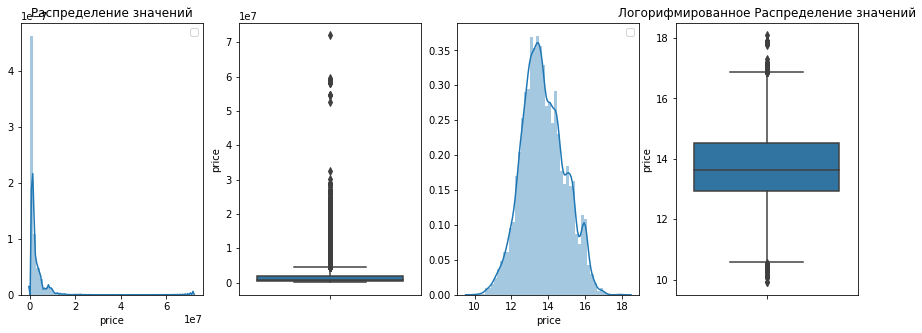

In [57]:
num_describer(df[df['Train']==1],'price')

In [58]:
# Распределение логнормальное, логарифмирование данного параметра явно улучшает картину с выбросами, но т.к. это целевая переменная логарифмировать не будем
# Выбросов 1%
# Рассмотри пропуски применительно к брэндам автомобилей
df[(df['Train']==1)&(df['price'].isna())]['brand'].value_counts()

VOLKSWAGEN    22
MERCEDES      21
KIA           21
TOYOTA        17
NISSAN        16
FORD          16
BMW           14
MITSUBISHI    13
HYUNDAI       13
RENAULT       11
CHEVROLET     11
VOLVO         10
AUDI          10
SKODA         10
MAZDA          9
OPEL           9
LAND_ROVER     8
PEUGEOT        8
HONDA          6
DAEWOO         5
LEXUS          5
CITROEN        5
INFINITI       4
SUBARU         3
SUZUKI         3
CHERY          3
JEEP           3
JAGUAR         2
DODGE          2
GREAT_WALL     2
SSANG_YONG     2
CHRYSLER       2
GEELY          2
PORSCHE        1
MINI           1
Name: brand, dtype: int64

In [59]:
# Надо удалить из трейна примеры с пропусками цена
index=df[(df['Train']==1)&(df['price'].isna())].index
df=df.drop(index)
print('удалено {} строк с пропущенными значениями'.format(len(index)))

удалено 290 строк с пропущенными значениями


In [60]:
df[df['Train']==1].price.value_counts(bins=6)

(-51980.001, 12016666.667]      70313
(12016666.667, 24013333.333]      685
(24013333.333, 36010000.0]         36
(48006666.667, 60003333.333]       11
(60003333.333, 72000000.0]          1
(36010000.0, 48006666.667]          0
Name: price, dtype: int64

In [61]:
index=df[(df['Train']==1)&(df['price']>24013333.333)].index
df=df.drop(index)
print('удалено {} строк с выбросами'.format(len(index)))

удалено 48 строк с выбросами


In [62]:
num_cols.append('price')

## Вывод price
РАспределение логномарльное,без выбросов.  
Удалено 290 пропусков в трейне и 48 выбросов сверху

## modelDate

доля пропусков : 0.0 
 min : 1904.0 
 25-й перцентиль: 2004.0 
 медиана: 2008.0 
 среднее: 2007.075 
 max : 2020.0 
 75-й перцентиль: 2012.0 
 IQR: 8.0 
 Границы выбросов: [1992.0, 2024.0] 
 Доля выбросов: 0.045



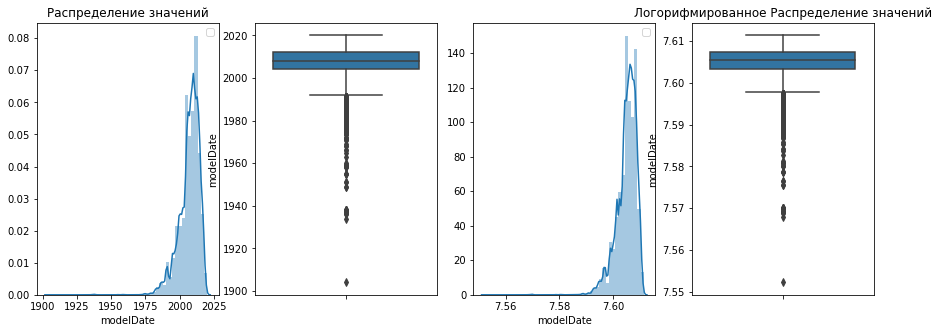

In [63]:
num_describer(df[df['Train']==0],'modelDate')

доля пропусков : 0.0 
 min : 1904.0 
 25-й перцентиль: 2005.0 
 медиана: 2010.0 
 среднее: 2009.525 
 max : 2020.0 
 75-й перцентиль: 2016.0 
 IQR: 11.0 
 Границы выбросов: [1988.5, 2032.5] 
 Доля выбросов: 0.0149



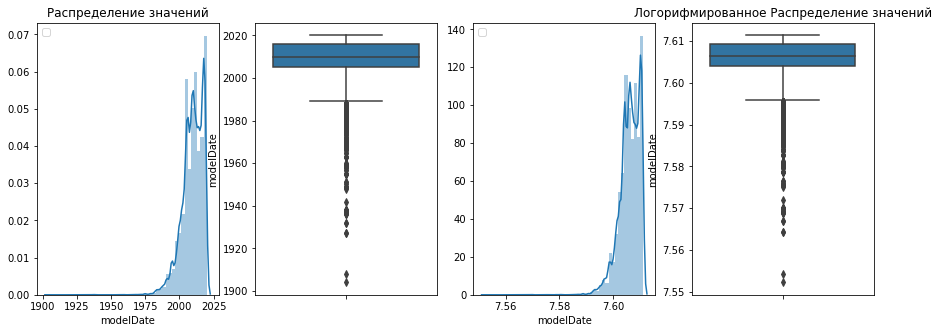

In [64]:
num_describer(df[df['Train']==1],'modelDate')

Судя по графикам и параметрам статистики данные собраны вполне релевантные. Совпадение в мин значение будет разобрано позже.  


In [65]:
index = df['modelDate'].index[df['modelDate'].apply(np.isnan)]
index

Int64Index([18760, 57456], dtype='int64')

In [66]:
df.loc[index]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,vendor,Train,sell_id
18760,nan,HONDA,серебристый,универсал,NaN,NaN,NaN,1989,NaN,NaN,NaN,0,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",400000,"{'id': '0', 'name': ''}",NaN,Левый,NaN,3.0,Оригинал,True,NaN,120000.0,2020-04-10,CIVIC,O,1,0
57456,nan,VOLKSWAGEN,синий,минивэн,NaN,NaN,NaN,1994,NaN,NaN,NaN,0,На ходу. Двигатель капитальный.,150000,"{'id': '0', 'name': ''}",NaN,Левый,NaN,3.0,Оригинал,True,NaN,300000.0,2020-02-21,TRANSPORTER,O,1,0


НУ тут либо автомобили были криво заполнены на сайте , либо криво скачались. Можем наблюдать и много пропусков и fuelType с bodyType местами поменялись.
удалю их

In [67]:
df=df.drop(index)

In [68]:
df['modelDate']=df['modelDate'].astype('int64')
num_cols.append('modelDate')

Можно добавить новый признак 'diffDate'='modelDate'-'productionDate'


In [69]:
df['diffDate']=df['productionDate']-df['modelDate']

In [70]:
num_cols.append('diffDate')

## Вывод modelDate

пара пропусков - битые записи
выбросов 1.5% , это не страшно, оставим.
удалено 2 пропуска
сгенерирован новый признак- diffDate, хранящий разницу между годом начала выпуска модели и выпуском конкретного автомобиля, в нем были обнаружены ошибки, они устранены.


## diffDate

In [71]:
df.diffDate.isnull().sum()

0

In [72]:
df.diffDate.value_counts()

 1     28730
 2     27259
 3     18881
 0     12287
 4     10051
 5      4044
 6      2100
 7       825
 8       549
 9       301
 10      189
 11      149
 12      102
 13       88
 14       45
-1        24
 15       20
 18       10
 16        5
-2         4
 35        4
 20        2
 22        2
 27        2
 34        2
 19        1
 21        1
 23        1
 25        1
 29        1
 46        1
-3         1
Name: diffDate, dtype: int64

In [73]:
df[df['diffDate']<0].shape

(29, 29)

In [74]:
# считаю что у автомобилей ошибки в данных
index=df[df['diffDate']<0].index
for i in index:
    df.loc[i,'productionDate']=int(df.loc[i,'modelDate'])
    
df['diffDate']=df['productionDate']-df['modelDate']


доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 1.0 
 медиана: 2.0 
 среднее: 2.19 
 max : 46 
 75-й перцентиль: 3.0 
 IQR: 2.0 
 Границы выбросов: [-2.0, 6.0] 
 Доля выбросов: 0.0161



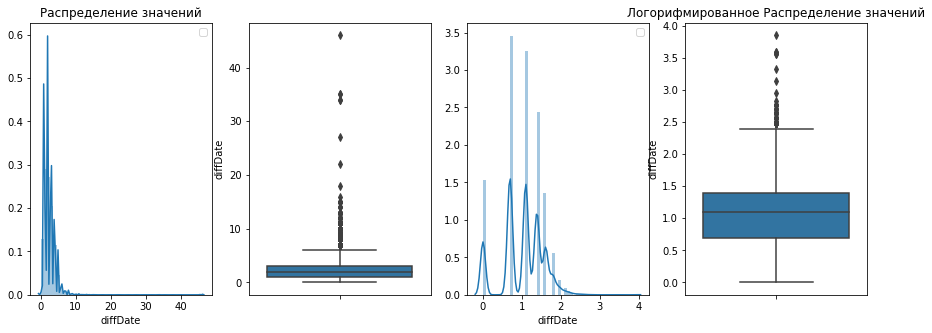

In [75]:
num_describer(df[df['Train']==0],'diffDate')

доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 1.0 
 медиана: 2.0 
 среднее: 2.217 
 max : 35 
 75-й перцентиль: 3.0 
 IQR: 2.0 
 Границы выбросов: [-2.0, 6.0] 
 Доля выбросов: 0.0246



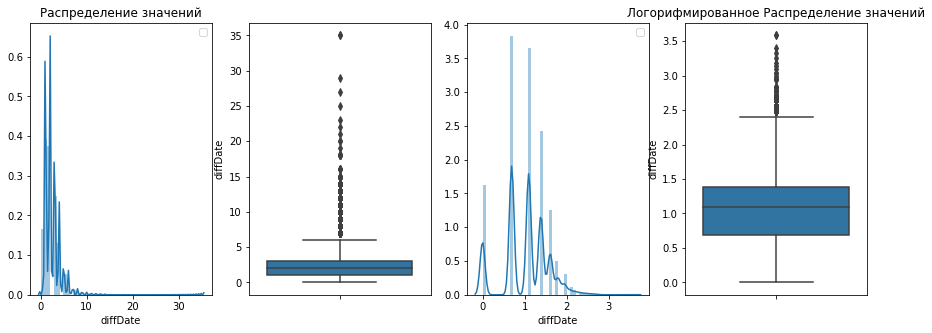

In [76]:
num_describer(df[df['Train']==1],'diffDate')

Как видно из графиков продается много автомобилей небольшого возраста, видимо люди продают автом через 2-3 года , как только заканчивается гарантия производителя  
Выбросов немного и связаны они с наличием раритетного автом и иных "старичков"

In [77]:
def borders_of_outliers(d_df,columns, log = False):
    num_df = d_df[columns]
    list_of_names = list(num_df.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    left_board=[]
    right_board=[]
    left_outliers=[]
    right_outliers=[]
    path_left_outliers=[]
    path_right_outliers=[]
    if log:
        log_left_board=[]
        log_right_board=[]
        log_left_outliers=[]
        log_right_outliers=[]
        log_path_left_outliers=[]
        log_path_right_outliers=[]
    for i in columns:
        IQR = num_df[i].quantile(0.75) - num_df[i].quantile(0.25)
        perc25 = num_df[i].quantile(0.25)
        perc75 = num_df[i].quantile(0.75)
        left_border = num_df[i].quantile(0.25) - 1.5*IQR
        right_border = perc75 + 1.5*IQR
        left_board.append(left_border)
        right_board.append(right_border)
        left_outliers.append((num_df[i]<left_border).sum())
        right_outliers.append((num_df[i]>right_border).sum())
        path_left_outliers.append((num_df[i]<left_border).sum()/len(num_df[i]))
        path_right_outliers.append((num_df[i]>right_border).sum()/len(num_df[i]))
        if log:
            num_df[i]=num_df[i].apply(lambda x: math.log(x+1))
            IQR = num_df[i].quantile(0.75) - num_df[i].quantile(0.25)
            perc25 = num_df[i].quantile(0.25)
            perc75 = num_df[i].quantile(0.75)
            left_border = num_df[i].quantile(0.25) - 1.5*IQR
            right_border = perc75 + 1.5*IQR
            log_left_board.append(left_border)
            log_right_board.append(right_border)
            log_left_outliers.append((num_df[i]<left_border).sum())
            log_right_outliers.append((num_df[i]>right_border).sum())
            log_path_left_outliers.append((num_df[i]<left_border).sum()/len(num_df[i]))
            log_path_right_outliers.append((num_df[i]>right_border).sum()/len(num_df[i]))
        
    temp_dict['левая граница'] = left_board
    temp_dict['правая граница'] = right_board
    temp_dict['выбросов слева'] = left_outliers
    temp_dict['выбросов справа'] = right_outliers
    temp_dict['доля выбросов слева'] = path_left_outliers
    temp_dict['доля выбросов справа'] = path_right_outliers
    
    if log:
        temp_dict['левая граница с логарифмом'] = log_left_board
        temp_dict['правая граница с логарифмом'] = log_right_board
        temp_dict['выбросов слева с логарифмом'] = log_left_outliers
        temp_dict['выбросов справа с логарифмом'] = log_right_outliers
        temp_dict['доля выбросов слева с логарифмом'] = log_path_left_outliers
        temp_dict['доля выбросов справа с логарифмом'] = log_path_right_outliers
    
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)
    
    return

In [78]:
borders_of_outliers(df[df['Train']==1],['diffDate'], log = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,имя признака,левая граница,правая граница,выбросов слева,выбросов справа,доля выбросов слева,доля выбросов справа,левая граница с логарифмом,правая граница с логарифмом,выбросов слева с логарифмом,выбросов справа с логарифмом,доля выбросов слева с логарифмом,доля выбросов справа с логарифмом
0,diffDate,-2,6,0,1744,0,0.0245648,-0.346574,2.42602,0,361,0,0.00508479


In [79]:
# Выбросов стало меньше и картина улучшилась
df['log_diffDate']=np.log(df['diffDate']+1)

In [80]:
num_cols.append('log_diffDate')

In [81]:
df=df.drop(['diffDate'],axis='columns')
num_cols.remove('diffDate')

## Вывод diffDate  
Выыбросов не много.  
Добавили логарифмированный признак т.к. он устраняет выбросы и растягивает картину, сам признак удалили

## productionDate

доля пропусков : 0.0 
 min : 1904 
 25-й перцентиль: 2006.0 
 медиана: 2011.0 
 среднее: 2009.265 
 max : 2020 
 75-й перцентиль: 2014.0 
 IQR: 8.0 
 Границы выбросов: [1994.0, 2026.0] 
 Доля выбросов: 0.0356



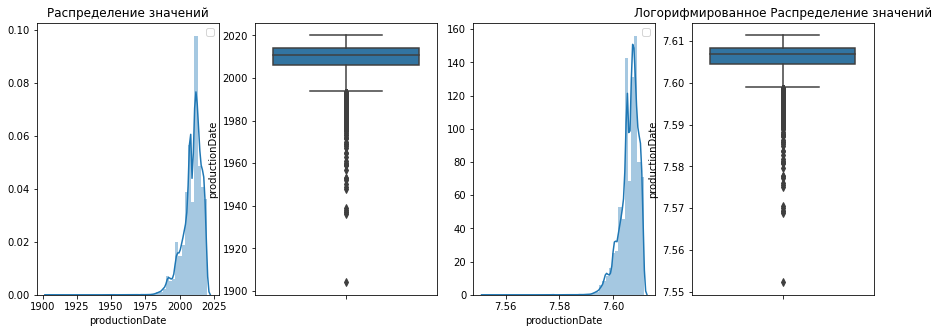

In [82]:
num_describer(df[df['Train']==0],'productionDate')

доля пропусков : 0.0 
 min : 1904 
 25-й перцентиль: 2008.0 
 медиана: 2012.0 
 среднее: 2011.743 
 max : 2020 
 75-й перцентиль: 2018.0 
 IQR: 10.0 
 Границы выбросов: [1993.0, 2033.0] 
 Доля выбросов: 0.0172



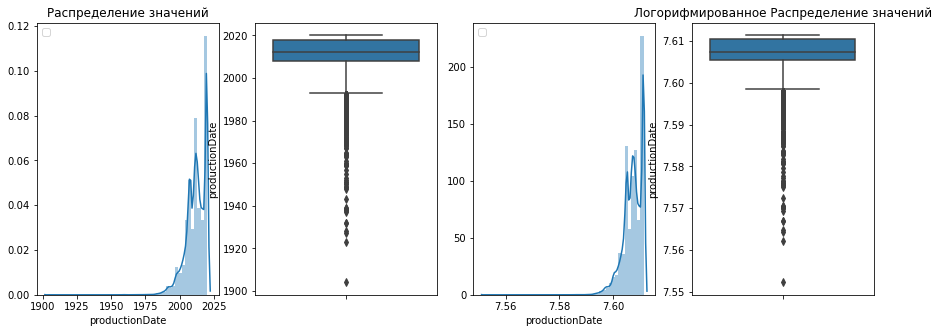

In [83]:
num_describer(df[df['Train']==1],'productionDate')

логарифмирование картину совсем не исправляетЮ все выбросы - возрастные авто

In [84]:
print('выбросов в тесте : {}'.format(df[(df['productionDate']<1994.0)&(df['Train']==0)].shape[0]))
print('выбросов в трейне : {}'.format(df[(df['productionDate']<1993.0)&(df['Train']==1)].shape[0]))

выбросов в тесте : 1236
выбросов в трейне : 1218


In [85]:
df['productionDate']=df['productionDate'].astype('int64')
num_cols.append('productionDate')

## Вывод productionDate
Пропусков нет, все выбросы - автом старше 26 лет, их количество примерно совпадает в трейне и тесте

## enginePower

доля пропусков : 0.0 
 min : 30 
 25-й перцентиль: 125.0 
 медиана: 169.0 
 среднее: 188.194 
 max : 639 
 75-й перцентиль: 233.0 
 IQR: 108.0 
 Границы выбросов: [-37.0, 395.0] 
 Доля выбросов: 0.0351



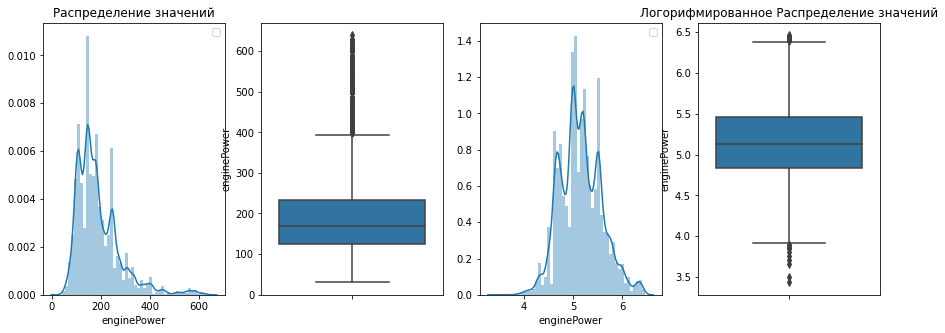

In [86]:
num_describer(df[df['Train']==0],'enginePower')

доля пропусков : 0.0 
 min : 11 
 25-й перцентиль: 117.0 
 медиана: 150.0 
 среднее: 179.386 
 max : 761 
 75-й перцентиль: 211.0 
 IQR: 94.0 
 Границы выбросов: [-24.0, 352.0] 
 Доля выбросов: 0.0575



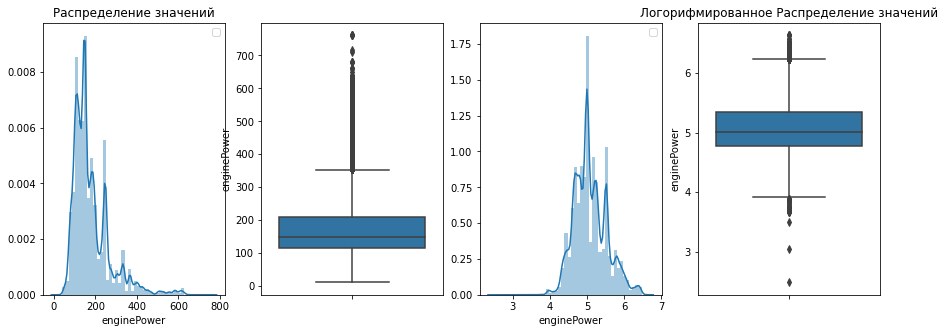

In [87]:
num_describer(df[df['Train']==1],'enginePower')

In [88]:
borders_of_outliers(df[df['Train']==1],['enginePower'], log = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,имя признака,левая граница,правая граница,выбросов слева,выбросов справа,доля выбросов слева,доля выбросов справа,левая граница с логарифмом,правая граница с логарифмом,выбросов слева с логарифмом,выбросов справа с логарифмом,доля выбросов слева с логарифмом,доля выбросов справа с логарифмом
0,enginePower,-24,352,0,4085,0,0.0575385,3.89183,6.23544,26,1050,0.000366218,0.0147896


РАспределение похоже на логнормальное, добавим новый признак с нормированными данными.


In [89]:
df[df['enginePower']<=30]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,vendor,Train,sell_id,log_diffDate
17520,кабриолет,FORD,зелёный,бензин,1908,2.9 MT (20 л.с.),2.0,1923,CABRIO MECHANICAL 2.9,механическая,2.9,20,1 октября 1908 Форд воплотил в жизнь свою мечт...,1000,{'id': '0'},задний,Левый,NaN,1.0,Оригинал,True,NaN,3800000.0,2018-12-26,MODEL_T,O,1,0,2.772589
45755,купе,RENAULT,чёрный,электро,2011,Electro AT (9 кВт),2.0,2016,COUPE AUTOMATIC Electro,автоматическая,Electro,11,"Идеальное состояние, использовался очень береж...",1800,"{'id': '20841229', 'name': 'CARGO', 'available...",задний,Левый,NaN,2.0,Оригинал,True,"{'year': 2018, 'month': 10}",549000.0,2020-07-22,TWIZY,O,1,0,1.791759
73113,хэтчбек 3 дв.,SKODA,чёрный,бензин,1934,1.1 MT (30 л.с.),3.0,1939,HATCHBACK_3_DOORS MECHANICAL 1.1,механическая,1.1,30,"Авто после длительного простоя, под восстановл...",14000,NaN,задний,Левый,Не требует ремонта,3.0,Оригинал,True,NaN,0.0,2020-10-20,POPULAR,EUROPEAN,0,1097046168,1.791759


2 в трейне, один в тесте. Конечно очень маленькое значение но оставлю это.

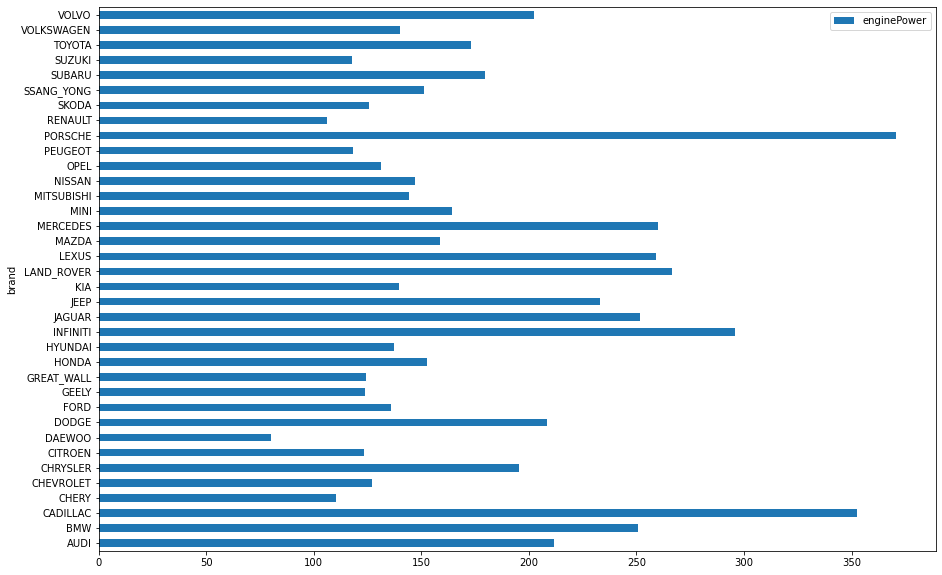

In [90]:
df[['brand','enginePower']][df['Train']==1].groupby(['brand']).mean().plot(kind='barh',figsize=(15,10))
#не догадался как отсортировать, подскажите))

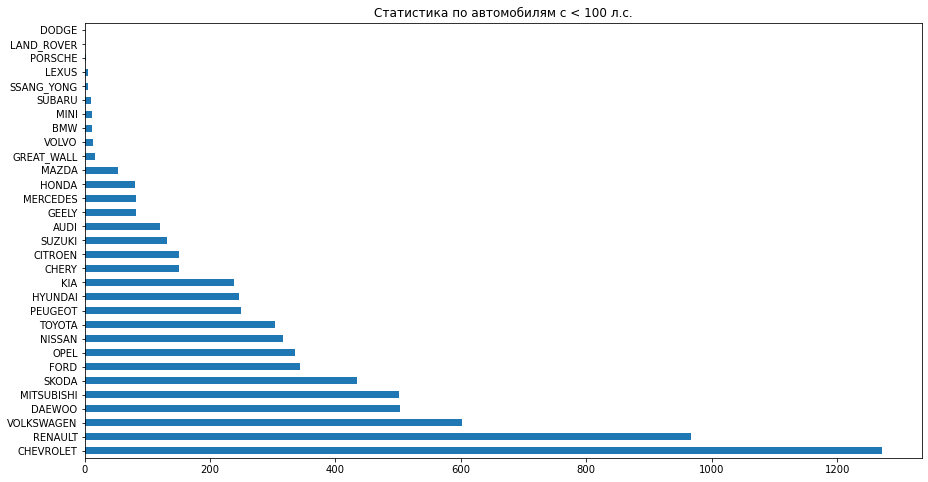

In [91]:
df[(df['Train']==1) & (df['enginePower']<100)]['brand'].value_counts().plot(kind = 'barh',figsize=(15, 8), title='Статистика по автомобилям с < 100 л.с.')

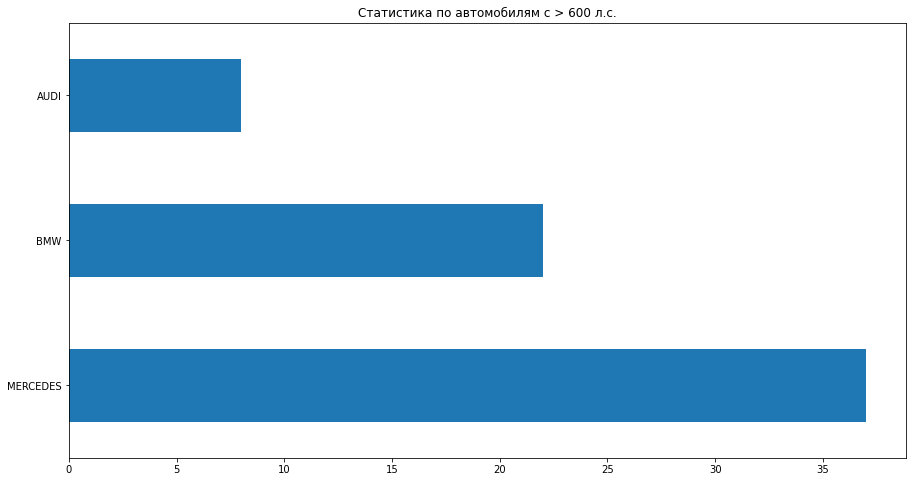

In [92]:
df[(df['Train']==0) & (df['enginePower']>600)]['brand'].value_counts().plot(kind = 'barh',figsize=(15, 8), title='Статистика по автомобилям с > 600 л.с.')

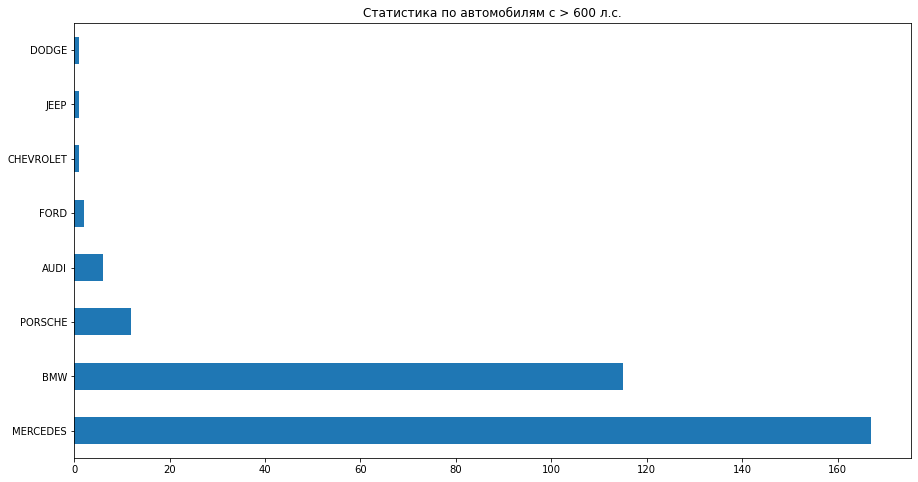

In [93]:
df[(df['Train']==1) & (df['enginePower']>600)]['brand'].value_counts().plot(kind = 'barh',figsize=(15, 8), title='Статистика по автомобилям с > 600 л.с.')

In [94]:
df[(df['Train']==1) & (df['enginePower']>639)].shape

(17, 29)

Выбросов не так много в данныз 3% и 5%. В тестовой выборке 19 записей, превышающих в данном параметре максимальное значение в тесте.  
Так же логарифмируем признак

In [95]:
df['log_enginePower']= np.log(df['enginePower']  +1)

In [96]:
num_cols.append('log_enginePower')
num_cols.append('enginePower')

## Вывод enginePower  
В данных имеется выброс, распределение логнормальное.  
Выявлены выбросы - крайне мощные авто, и выбросы - "старички" и  электрокар. данные выбраны для потенциального удаления.  
Сгенерирован новый признак log_enginePower

##  log_enginePower

доля пропусков : 0.0 
 min : 3.4339872044851463 
 25-й перцентиль: 4.836281906951478 
 медиана: 5.135798437050262 
 среднее: 5.15 
 max : 6.461468176353717 
 75-й перцентиль: 5.455321115357702 
 IQR: 0.6190392084062237 
 Границы выбросов: [3.908, 6.384] 
 Доля выбросов: 0.0025



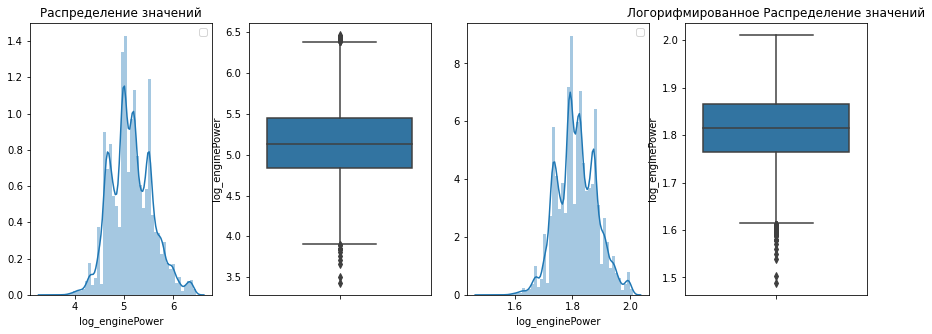

In [97]:
num_describer(df[df['Train']==0],'log_enginePower')

доля пропусков : 0.0 
 min : 2.4849066497880004 
 25-й перцентиль: 4.770684624465665 
 медиана: 5.017279836814924 
 среднее: 5.092 
 max : 6.635946555686647 
 75-й перцентиль: 5.356586274672012 
 IQR: 0.5859016502063472 
 Границы выбросов: [3.892, 6.235] 
 Доля выбросов: 0.0152



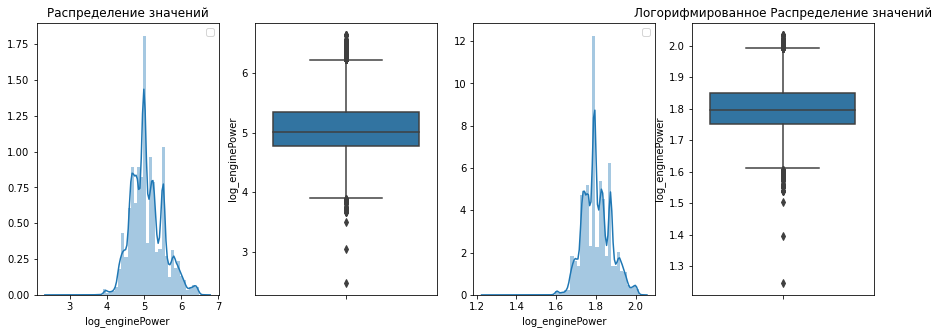

In [98]:
num_describer(df[df['Train']==1],'log_enginePower')

## Вывод log_enginePower  
Выбросов мало, фактически нет. выборки по данному параметру очень релевантны

## mileage

In [99]:
df['mileage'] = df['mileage'].astype('int64')

доля пропусков : 0.0 
 min : 1 
 25-й перцентиль: 91153.5 
 медиана: 149779.5 
 среднее: 162009.768 
 max : 1000000 
 75-й перцентиль: 215000.0 
 IQR: 123846.5 
 Границы выбросов: [-94616.25, 400769.75] 
 Доля выбросов: 0.02



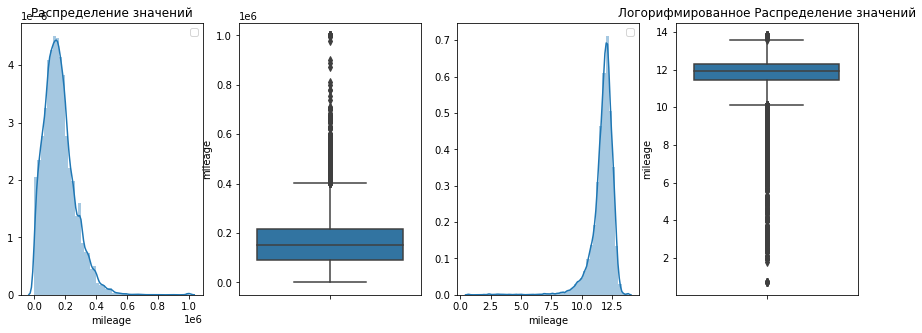

In [100]:
num_describer(df[df['Train']==0],'mileage')

доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 30000.0 
 медиана: 116000.0 
 среднее: 123402.423 
 max : 1000000 
 75-й перцентиль: 186000.0 
 IQR: 156000.0 
 Границы выбросов: [-204000.0, 420000.0] 
 Доля выбросов: 0.0099



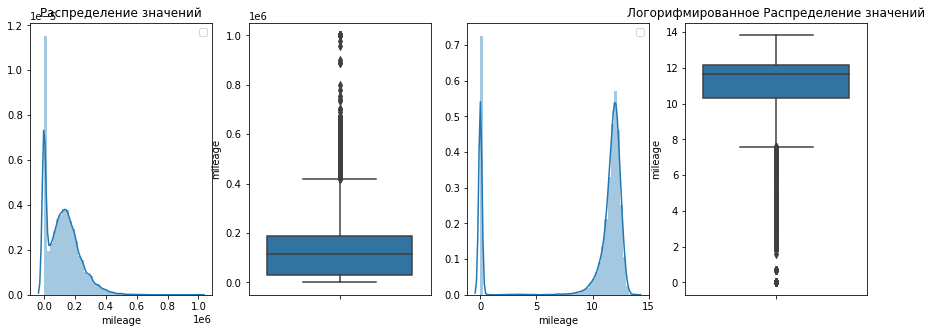

In [101]:
num_describer(df[df['Train']==1],'mileage')

Явное отличие тестовой и обучающей выборки по данному параметру. В трейне много авто с околонулевым пробегом, надо проверить

доля пропусков : 0.0 
 min : 1 
 25-й перцентиль: 88800.0 
 медиана: 142000.0 
 среднее: 154331.285 
 max : 1000000 
 75-й перцентиль: 201639.25 
 IQR: 112839.25 
 Границы выбросов: [-80458.875, 370898.125] 
 Доля выбросов: 0.0264



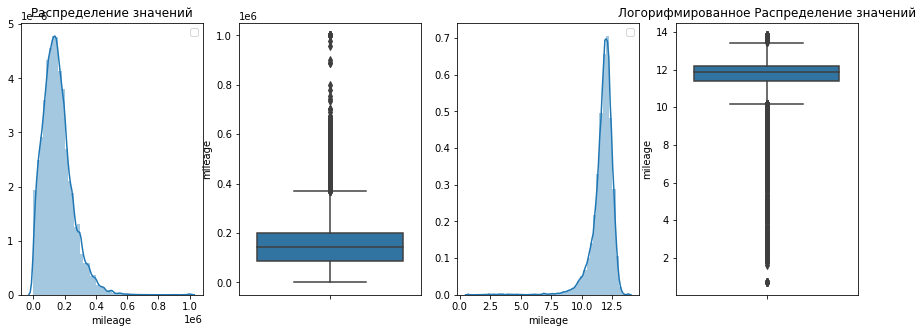

In [102]:
num_describer(df[(df['Train']==1)&(df['mileage']>0)],'mileage')

In [103]:
#видимо попали новые автомобили
print(len(df[(df['mileage']==0)&(df['Train']==1)])/len(df[df['Train']==1]))

0.20040565665671306


много, это почти 20% обучающей выборки, надо запомнить. потенциально к удалению.

0.21502619865907938


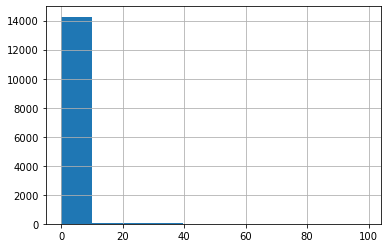

In [104]:
print(len(df[(df['mileage']<10000)&(df['Train']==1)])/len(df[df['Train']==1]))
df[(df['mileage']<100)&(df['Train']==1)].mileage.hist()

0.01256408811764043


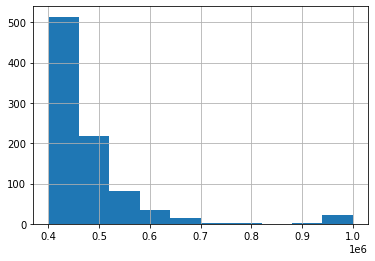

In [105]:
print(len(df[(df['mileage']>400769.75)&(df['Train']==1)])/len(df[df['Train']==1]))
df[(df['mileage']>400769.75)&(df['Train']==1)].mileage.hist()

Выбросов сверху немного, можно оставить.  
Добавим новые признаки - age и annual_mileage(содержащий средний пробег за год)

In [106]:
borders_of_outliers(df,['mileage'],log=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,имя признака,левая граница,правая граница,выбросов слева,выбросов справа,доля выбросов слева,доля выбросов справа,левая граница с логарифмом,правая граница с логарифмом,выбросов слева с логарифмом,выбросов справа с логарифмом,доля выбросов слева с логарифмом,доля выбросов справа с логарифмом
0,mileage,-153759,405856,0,1518,0,0.0143638,9.05829,14.0624,15756,0,0.149089,0


логарифмирование ухудшает положение с выбросами

In [107]:
df['age']=2020-df['productionDate']

In [108]:
df[df['age']==0]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,vendor,Train,sell_id,log_diffDate,log_enginePower,age
256,седан,AUDI,серебристый,бензин,2016,1.4 AMT (150 л.с.),4.0,2020,SEDAN ROBOT 1.4,роботизированная,1.4,150,Эксклюзивные условия в Ауди Центре Север.\nТол...,0,"{'id': '21597097', 'name': '35 TFSI S tronic',...",передний,Левый,NaN,NaN,Оригинал,True,NaN,1885000.0,2020-10-12,A3,O,1,0,1.609438,5.017280,0
263,седан,AUDI,серебристый,бензин,2016,1.4 AMT (150 л.с.),4.0,2020,SEDAN ROBOT 1.4,роботизированная,1.4,150,Эксклюзивные условия в Ауди Центре Север.\nТол...,0,"{'id': '21597097', 'name': '35 TFSI S tronic',...",передний,Левый,NaN,NaN,Оригинал,True,NaN,1885400.0,2020-10-12,A3,O,1,0,1.609438,5.017280,0
265,седан,AUDI,серый,бензин,2016,1.4 AMT (150 л.с.),4.0,2020,SEDAN ROBOT 1.4,роботизированная,1.4,150,Новый дилерский центр Ауди в Москве.\n\nУникал...,0,"{'id': '20838807', 'name': 'Basis', 'available...",передний,Левый,NaN,NaN,Оригинал,True,NaN,1885400.0,2020-10-08,A3,O,1,0,1.609438,5.017280,0
267,седан,AUDI,белый,бензин,2016,1.4 AMT (150 л.с.),4.0,2020,SEDAN ROBOT 1.4,роботизированная,1.4,150,«СКИДКА ТОЛЬКО ПРИ ПРОДАЖЕ В КРЕДИТ ИЛИ TRADE ...,12848,{'id': '0'},передний,Левый,NaN,1.0,Оригинал,True,NaN,1749000.0,2020-11-18,A3,O,1,0,1.609438,5.017280,0
275,седан,AUDI,белый,бензин,2016,1.4 AMT (150 л.с.),4.0,2020,SEDAN ROBOT 1.4,роботизированная,1.4,150,Месяц рекордных продаж Audi A3\nДарим ТО при п...,0,"{'id': '21597097', 'name': '35 TFSI S tronic',...",передний,Левый,NaN,NaN,Оригинал,True,NaN,1885400.0,2020-11-02,A3,O,1,0,1.609438,5.017280,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105565,внедорожник 5 дв.,MERCEDES,чёрный,дизель,2018,350 d 2.9d AT (249 л.с.) 4WD,5.0,2020,ALLROAD_5_DOORS AUTOMATIC 2.9,автоматическая,2.9,249,"Автомобиль дилерский, новый\nАвтомобиль с НДС....",15,"{""id"":""21735776"",""name"":""G 350 d"",""available_o...",полный,Левый,Не требует ремонта,1.0,Оригинал,True,1 месяц,0.0,2020-10-26,G_KLASSE,EUROPEAN,0,1101051434,1.098612,5.521461,0
105802,внедорожник 5 дв.,NISSAN,белый,бензин,2017,2.0 CVT (144 л.с.) 4WD,5.0,2020,ALLROAD_5_DOORS VARIATOR 2.0,вариатор,2.0,144,"Автомобиль в идеальном состоянии, как новый, н...",11651,NaN,полный,Левый,Не требует ремонта,2.0,Оригинал,True,8 месяцев,0.0,2020-10-26,X_TRAIL,JAPANESE,0,1101363335,1.386294,4.976734,0
105905,внедорожник 5 дв.,TOYOTA,голубой,бензин,2018,2.0 CVT (149 л.с.) 4WD,5.0,2020,ALLROAD_5_DOORS VARIATOR 2.0,вариатор,2.0,149,"Автомобиль в идеале владею 3-4 месяца,авто в к...",12000,"{""id"":""21678548"",""name"":""Комфорт"",""available_o...",полный,Левый,Не требует ремонта,1.0,Оригинал,True,NaN,0.0,2020-10-26,RAV_4,JAPANESE,0,1101367840,1.098612,5.010635,0
105910,внедорожник 5 дв.,TOYOTA,чёрный,дизель,2015,4.5d AT (249 л.с.) 4WD,5.0,2020,ALLROAD_5_DOORS AUTOMATIC 4.5,автоматическая,4.5,249,Автомобиль в максимальной комплектации Executi...,15000,"{""id"":""21394991"",""name"":""Executive Lounge"",""av...",полный,Левый,Не требует ремонта,1.0,Оригинал,True,4 месяца,0.0,2020-10-26,LAND_CRUISER,JAPANESE,0,1101367010,1.791759,5.521461,0


In [109]:
#для новых авто прибавим один год, чтобы не было деления на 0, все равно у них пробег нулевой и в нужном параметре будет стоять 0
df['age']=df['age'].apply(lambda x: 1 if x==0 else x)
df['annual_mileage']=round(df['mileage']/df['age'],2)
df=df.drop(['age'],axis='columns')
num_cols.append('annual_mileage')

## Вывод mileage
Выбросов немного , ~1% в обеих выборках, но в трейн попало много новых автомобилей- 20%, это плохо и может серьезно повлиять на результат работы модели.
Сгенерирован новый признак - annual_mileage, годовой пробег, который отразит интенсивность использования авто.

## annual_mileage

доля пропусков : 0.0 
 min : 0.01 
 25-й перцентиль: 11666.67 
 медиана: 15487.945 
 среднее: 17084.291 
 max : 124400.0 
 75-й перцентиль: 20333.33 
 IQR: 8666.660000000002 
 Границы выбросов: [-1333.32, 33333.32] 
 Доля выбросов: 0.047



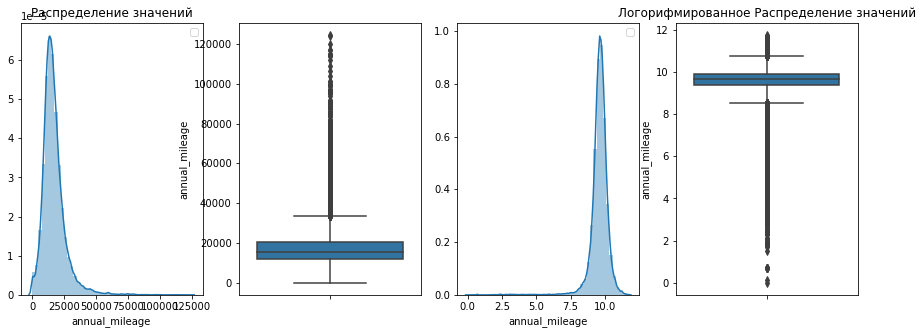

In [110]:
num_describer(df[df['Train']==0],'annual_mileage')

доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 6713.7175 
 медиана: 13333.33 
 среднее: 13625.16 
 max : 150000.0 
 75-й перцентиль: 18750.0 
 IQR: 12036.282500000001 
 Границы выбросов: [-11340.706, 36804.424] 
 Доля выбросов: 0.0292



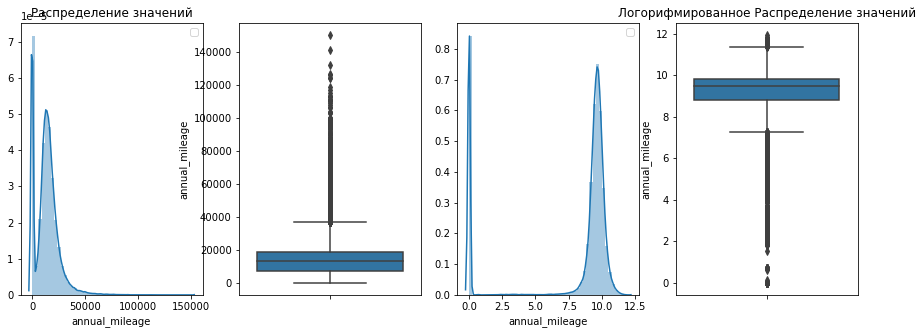

In [111]:
num_describer(df[df['Train']==1],'annual_mileage')

доля пропусков : 0.0 
 min : 0.14 
 25-й перцентиль: 11400.0 
 медиана: 15317.16 
 среднее: 17040.09 
 max : 150000.0 
 75-й перцентиль: 20333.33 
 IQR: 8933.330000000002 
 Границы выбросов: [-1999.995, 33733.325] 
 Доля выбросов: 0.0485



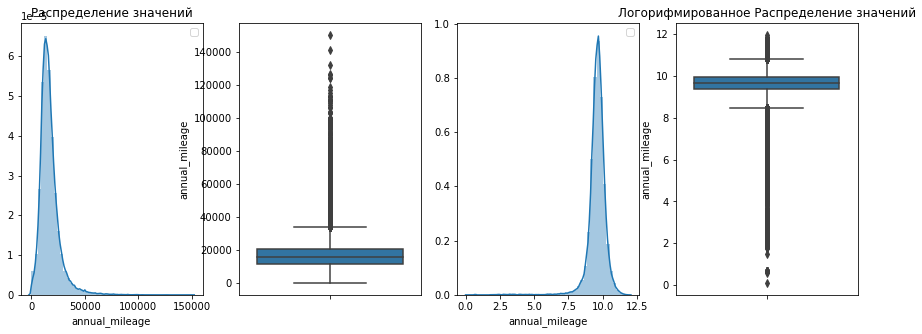

In [112]:
num_describer(df[(df['Train']==1)&(df['annual_mileage']>0)],'annual_mileage')

## Вывод annual_mileage  
Выбросов немного, 4.7% в тесте и 3% в трейне. Опять новые автомобили, если их убрать то описательные характеристики тестовой и тренировочной выборку будут почти одинаковми.Однако мне все еще не дает покоя то , что новых автомобилей слишком большой процент

## numberOfDoors

доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 4.0 
 медиана: 5.0 
 среднее: 4.451 
 max : 5.0 
 75-й перцентиль: 5.0 
 IQR: 1.0 
 Границы выбросов: [2.5, 6.5] 
 Доля выбросов: 0.0348



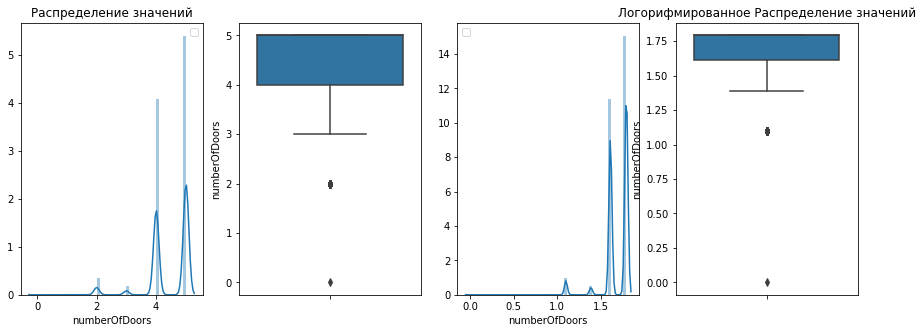

In [113]:
num_describer(df[df['Train']==0],'numberOfDoors')

In [114]:
def obj_param_describe(df,param):
    print('доля пропусков: ',df[param].isnull().sum()/len(df[param]))
    print('Значения параметра и их количество')
    df[param].value_counts().plot(kind='barh',figsize=(10, 10))
    print(df[param].value_counts())
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    sns.boxplot(x=param, y='price', data=df)

доля пропусков:  0.0
Значения параметра и их количество
5.0    43547
4.0    24072
3.0     1781
2.0     1595
0.0        1
Name: numberOfDoors, dtype: int64


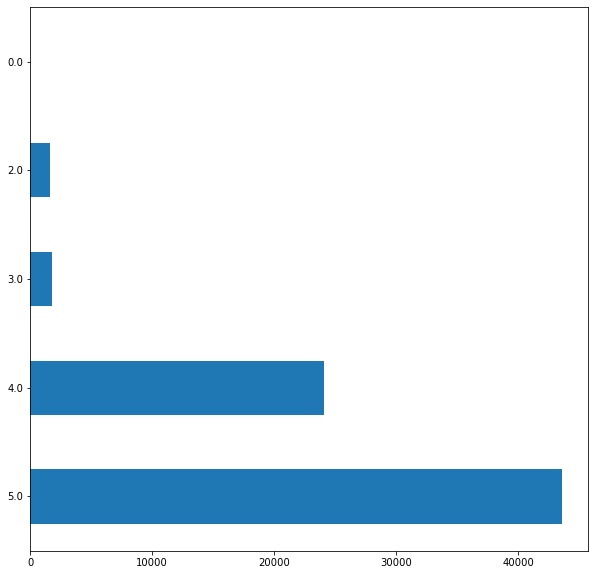

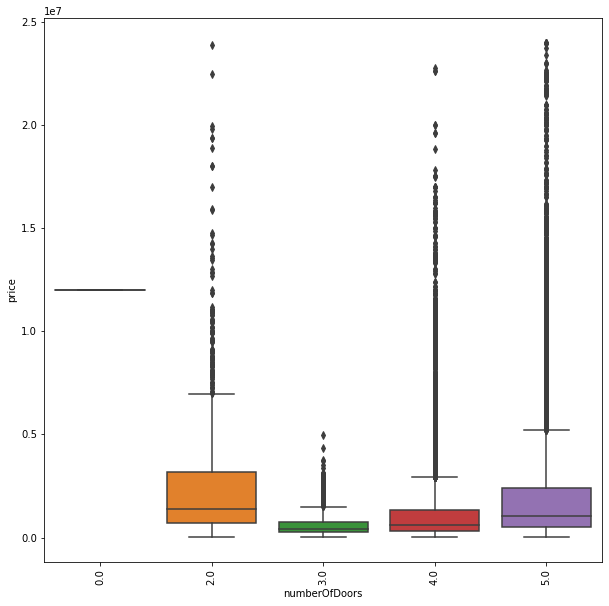

In [115]:
obj_param_describe(df[df['Train']==1],'numberOfDoors')

Распределение по количеству дверей очевидно, наглядно продемонстрировано что количество дверей на цену не влияет, глянем на автомобили с 0 дверей)

In [116]:
df[df['numberOfDoors']==0]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,vendor,Train,sell_id,log_diffDate,log_enginePower,annual_mileage
70346,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0.0,1904,CABRIO MECHANICAL 5.3,механическая,5.3,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,{'id': '0'},задний,Правый,NaN,1.0,Оригинал,True,"{'year': 2014, 'month': 2}",12000000.0,2019-11-20,SIMPLEX,O,1,0,0.0,3.496508,413.79
88280,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0.0,1904,CABRIO MECHANICAL 5.3,механическая,5.3,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,NaN,задний,Правый,Не требует ремонта,1.0,Оригинал,True,6 лет и 8 месяцев,0.0,2020-10-21,SIMPLEX,EUROPEAN,0,1093802104,0.0,3.496508,413.79


Неожиданно встретить такое совпадение))

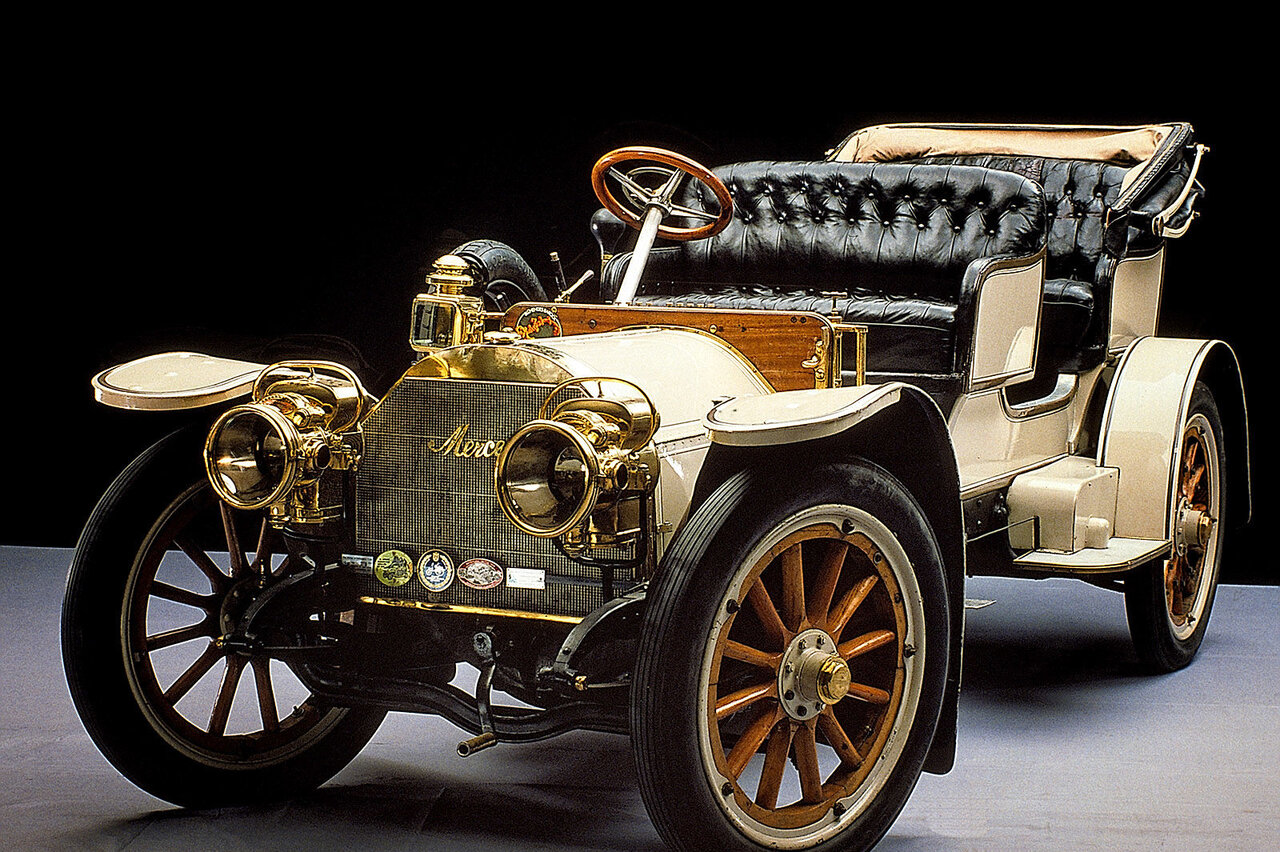

вот он бездверный кабриолет 1904 года выпуска))

## Вывод numberOfDoors  
Выбросов нет, все штатно. Обнаружено интересное совпадение)

## vendor

vendor отображает какой брэнд европейский или азиатский, считаю что это влияет на гарантию т.к.  
европейский стандарт, включает исключительно временной показатель – 2 года без ограничения по пробегу  
азиатский – 3 года или 100 000 км.  
Мы не будем разбирать вкусовщину в плане европейцев и японцев)) а выявим автомобили которые на гарантии

In [117]:
df.vendor.value_counts()

O           70996
EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

In [118]:
df['brand']=df['brand'].apply(lambda x: str(x).lower())

In [119]:
df[df['vendor']=='EUROPEAN'].brand.value_counts()

bmw           4473
volkswagen    4404
mercedes      4180
audi          3421
skoda         2741
volvo         1463
Name: brand, dtype: int64

In [120]:
df[df['vendor']=='JAPANESE'].brand.value_counts()

nissan        4393
toyota        3913
mitsubishi    2843
honda         1150
infiniti       871
lexus          834
Name: brand, dtype: int64

In [121]:
# проставим вендора по имеющимся спискам
europ=df[df['vendor']=='EUROPEAN'].brand.unique().tolist()
japan=df[df['vendor']=='JAPANESE'].brand.unique().tolist()

In [122]:
df[(~df['brand'].isin(europ))&(~df['brand'].isin(japan))].brand.unique()

array(['cadillac', 'chery', 'chevrolet', 'chrysler', 'citroen', 'daewoo',
       'dodge', 'ford', 'geely', 'hyundai', 'jaguar', 'jeep', 'kia',
       'mazda', 'mini', 'opel', 'peugeot', 'porsche', 'renault', 'subaru',
       'suzuki', 'great_wall', 'land_rover', 'ssang_yong'], dtype=object)

In [123]:
#Для этих брендов тожде надо определить правила по страховке:  
#азиатский стандарт - cadillac,  chevrolet,citroen ,daewoo,ford,hyundai,kia,mazda,renault,subaru,suzuki,great_wall,ssang_yong
#европейский стандарт -   chrysler,dodge,jeep,opel,peugeot,porsche,land_rover
#иной:
#5лет или 150тыс пробега : chery
#4 года или 1000тыс пробега : geely
# 3 years jaguar

In [124]:
europ=europ+['chrysler','dodge','jeep','opel','peugeot','porsche','land_rover']
japan=japan+['cadillac',  'chevrolet','citroen' ,'daewoo','ford','hyundai','kia','mazda','renault','subaru','suzuki','great_wall','ssang_yong']

In [125]:
df['Guarantee']=False

In [126]:
df.loc[df[(df['brand'].isin(europ))&(df['productionDate']>=2018)].index,'Guarantee']=True
df.loc[df[(df['brand'].isin(japan))&(df['productionDate']>=2017)&(df['mileage']<100000)].index,'Guarantee']=True
df.loc[df[(df['brand']=='chery')&(df['productionDate']>=2015)&(df['mileage']<150000)].index,'Guarantee']=True
df.loc[df[(df['brand']=='geely')&(df['productionDate']>=2065)&(df['mileage']<100000)].index,'Guarantee']=True
df.loc[df[(df['brand']=='jaguar')&(df['productionDate']>=2075)].index,'Guarantee']=True

In [127]:
df['Guarantee'].value_counts()

False    82656
True     23026
Name: Guarantee, dtype: int64

In [128]:
bin_cols.append('Guarantee')
df=df.drop(['vendor'],axis='columns')

доля пропусков:  0.0
Значения параметра и их количество
False    51259
True     19737
Name: Guarantee, dtype: int64


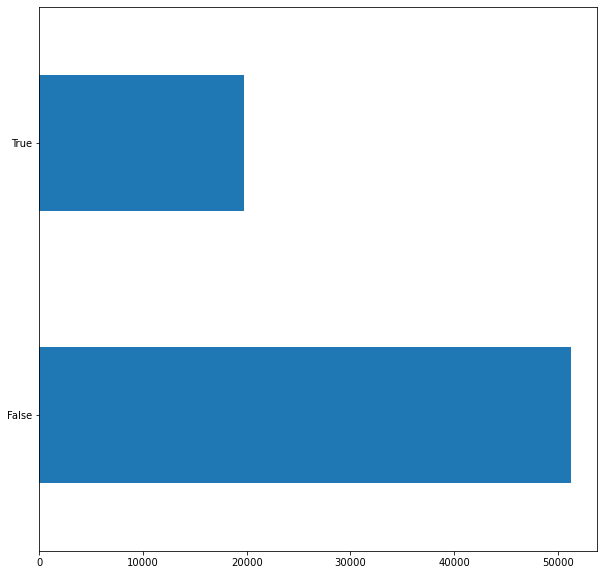

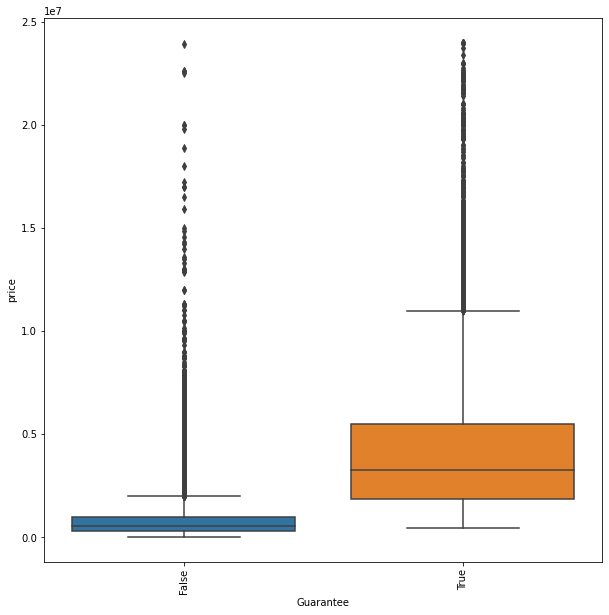

In [129]:
obj_param_describe(df[df['Train']==1],'Guarantee')

## Вывод vendor
 добавили новый бинарный признак - Guarantee

## owners

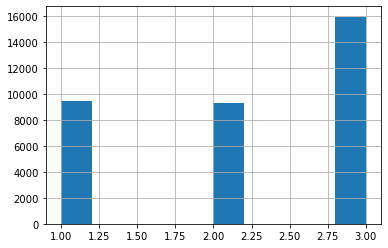

In [130]:
df[df['Train']==0].owners.hist()

доля пропусков:  0.20040565665671306
Значения параметра и их количество
3.0    25192
1.0    16311
2.0    15265
Name: owners, dtype: int64


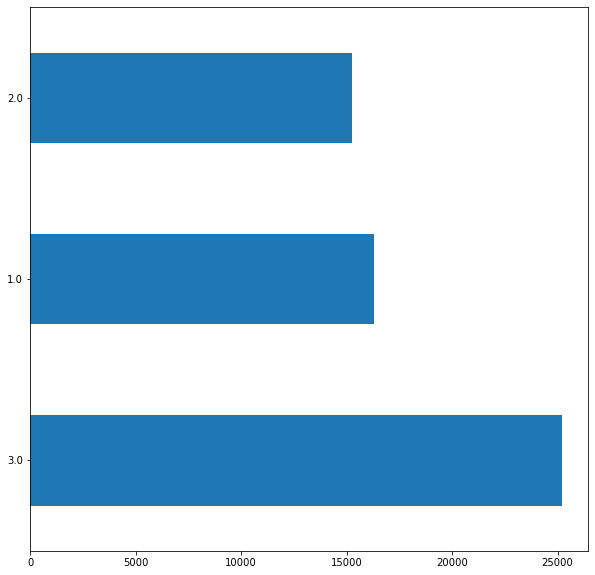

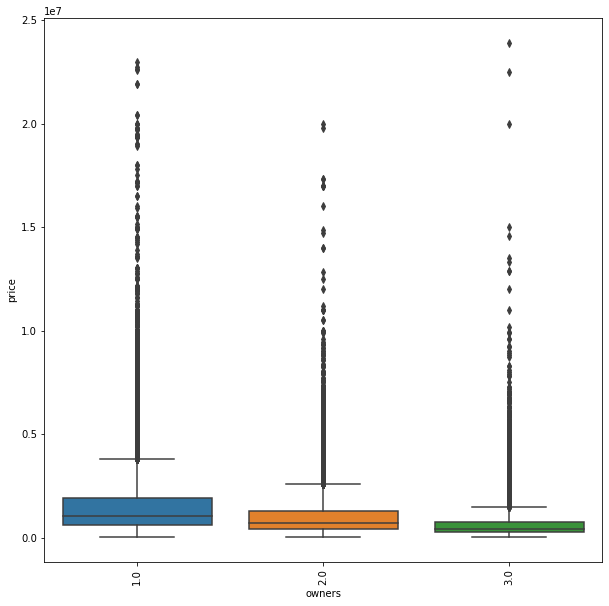

In [131]:
obj_param_describe(df[df['Train']==1],'owners')

In [132]:
df['owners']=df['owners'].fillna(0)

доля пропусков:  0.0
Значения параметра и их количество
3.0    25192
1.0    16311
2.0    15265
0.0    14228
Name: owners, dtype: int64


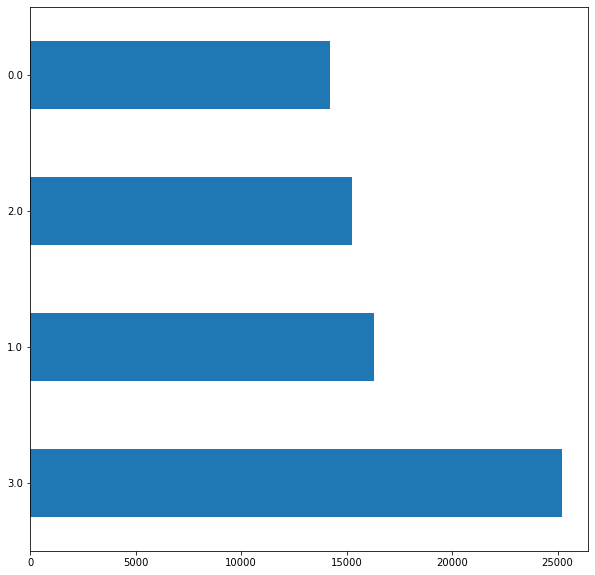

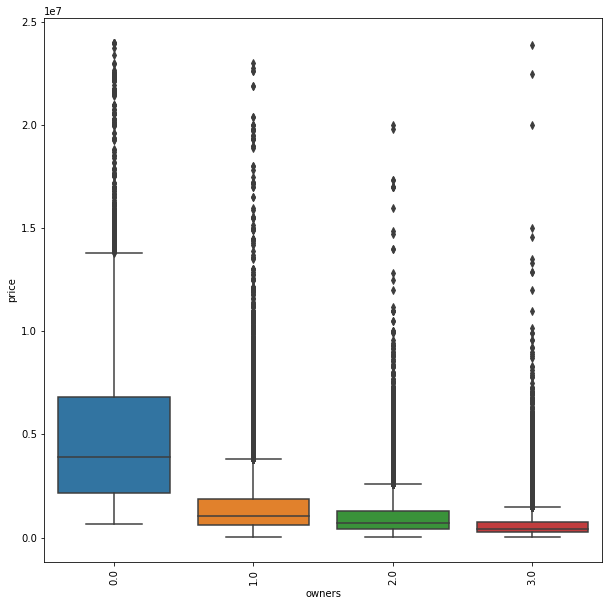

In [133]:
obj_param_describe(df[df['Train']==1],'owners')

## Вывод owners
Опять новые автомобили(((  
Как видим количество владельцев не слишком сильно сказывается на цене. У новых автомобилей в этом плане все более стабильно

## bodyType

In [134]:
df[df['Train']==0].bodyType.unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

In [135]:
df[df['Train']==1].bodyType.unique()

array(['седан', 'универсал 5 дв.', 'хэтчбек 5 дв. sportback',
       'хэтчбек 3 дв.', 'хэтчбек 5 дв.', 'кабриолет', 'купе',
       'лифтбек sportback', 'лифтбек', 'седан long', 'внедорожник 5 дв.',
       'кабриолет roadster', 'седан 2 дв.', 'седан gran coupe',
       'компактвэн', 'компактвэн gran tourer', 'лифтбек gran turismo',
       'хэтчбек 3 дв. compact', 'лифтбек gran coupe', 'купе-хардтоп',
       'родстер roadster', 'родстер', 'седан 4-window',
       'внедорожник 5 дв. esv', 'пикап двойная кабина', 'минивэн',
       'внедорожник 3 дв.', 'пикап одинарная кабина', 'тарга',
       'седан 2 дв. styleline', 'пикап двойная кабина crew cab',
       'пикап двойная кабина double', 'внедорожник 5 дв. ext',
       'седан srt8', 'минивэн swb', 'минивэн grand', 'компактвэн grand',
       'минивэн long', 'минивэн xl', 'микровэн coach',
       'хэтчбек 5 дв. best', 'хэтчбек 5 дв. srt4', 'купе srt8',
       'купе srt', 'седан srt', 'пикап полуторная кабина',
       'пикап одинарная кабина r

Как можно заметить в основном в трейне встречаются такие же типы кузовов как в тесте, но с уточнениями/дополнениями, например 'универсал 5 дв.' и 'универсал 5 дв. blit'. Приведем типы кузовов в трейне к такому же виду как в тесте функцией, а что останется - руками лично

In [136]:
df[df['Train']==0].bodyType.unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

In [137]:
bodyTypes=[ 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон','седан', 'купе','лифтбек']
#переставим ручками простые типы кузова('седан', 'купе','лифтбек') в конец
def bodyType_normolize(body):
    if body in bodyTypes:
        return body#чтобы 'купе-хардтоп' не превратилось в 'купе', аналогично с седанами
    else:
        for i in bodyTypes:
            if i in body:
                return i
        return body
        
df.bodyType=df.bodyType.apply(lambda x: bodyType_normolize(str(x)))

In [138]:
df[df['Train']==1].bodyType.unique()

array(['седан', 'универсал 5 дв.', 'хэтчбек 5 дв.', 'хэтчбек 3 дв.',
       'кабриолет', 'купе', 'лифтбек', 'внедорожник 5 дв.', 'седан 2 дв.',
       'компактвэн', 'купе-хардтоп', 'родстер', 'пикап двойная кабина',
       'минивэн', 'внедорожник 3 дв.', 'пикап одинарная кабина', 'тарга',
       'микровэн', 'пикап полуторная кабина', 'внедорожник открытый',
       'фастбек', 'хэтчбек 4 дв.', 'седан-хардтоп', 'фургон', 'лимузин'],
      dtype=object)

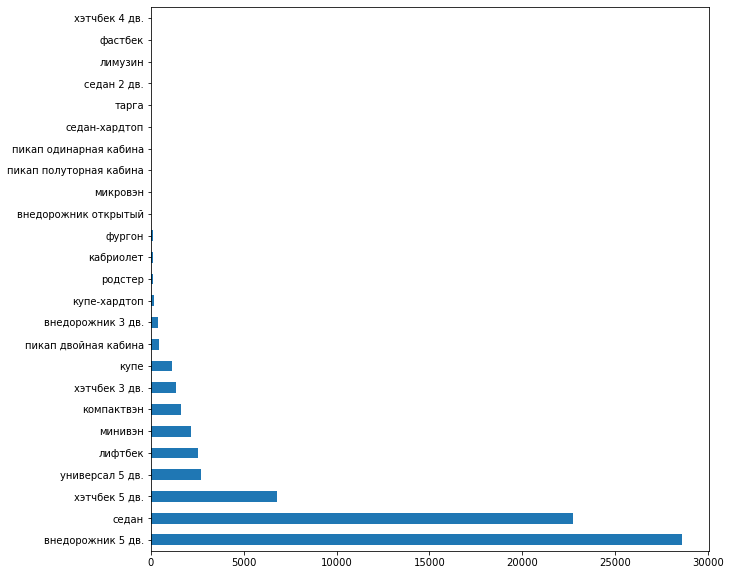

In [139]:
df[df['Train']==1].bodyType.value_counts().plot(kind='barh',figsize=(10,10))

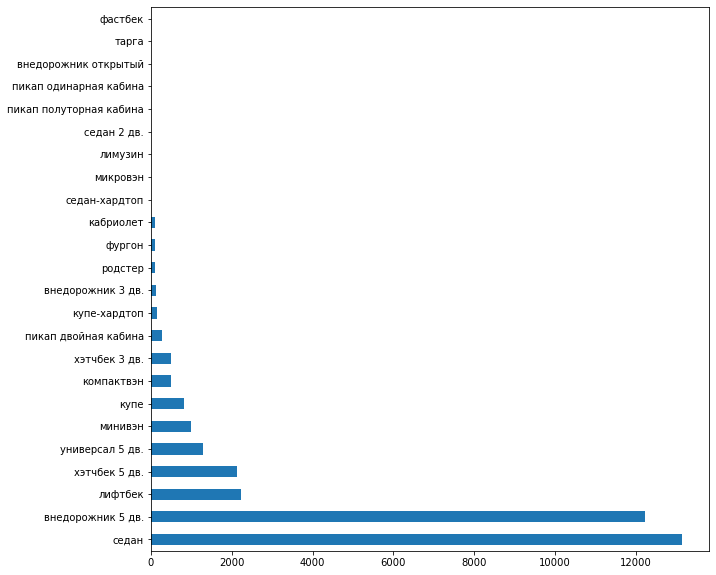

In [140]:
df[df['Train']==0].bodyType.value_counts().plot(kind='barh',figsize=(10,10))

Распределение типов кузовов в трейне и тесте примерно одинаково, поменялись местами лифтбек,хэтчбек 5дв.,универсал 5дв.  
Популярность седанов и внедорожников 5дв очевидна

доля пропусков:  0.0
Значения параметра и их количество
внедорожник 5 дв.          28633
седан                      22738
хэтчбек 5 дв.               6791
универсал 5 дв.             2674
лифтбек                     2517
минивэн                     2165
компактвэн                  1606
хэтчбек 3 дв.               1328
купе                        1109
пикап двойная кабина         420
внедорожник 3 дв.            390
купе-хардтоп                 164
родстер                      130
кабриолет                    124
фургон                       101
внедорожник открытый          23
микровэн                      22
пикап полуторная кабина       15
пикап одинарная кабина        13
седан-хардтоп                 11
тарга                          7
седан 2 дв.                    6
лимузин                        5
фастбек                        2
хэтчбек 4 дв.                  2
Name: bodyType, dtype: int64


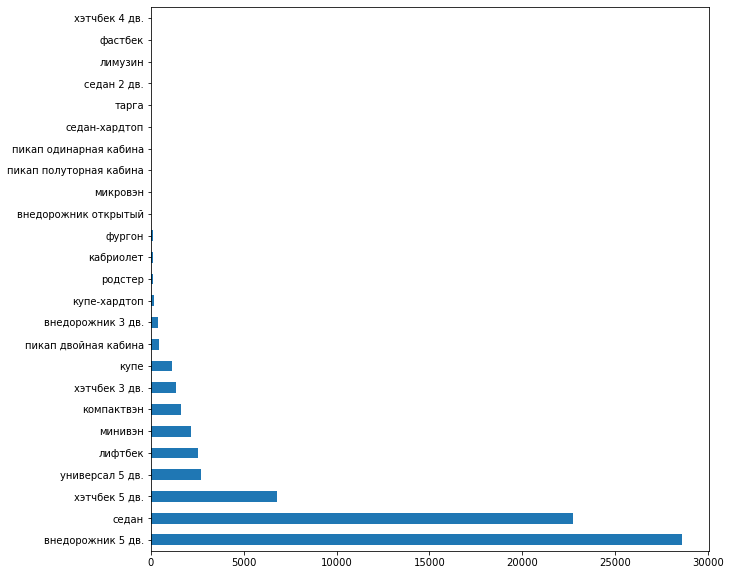

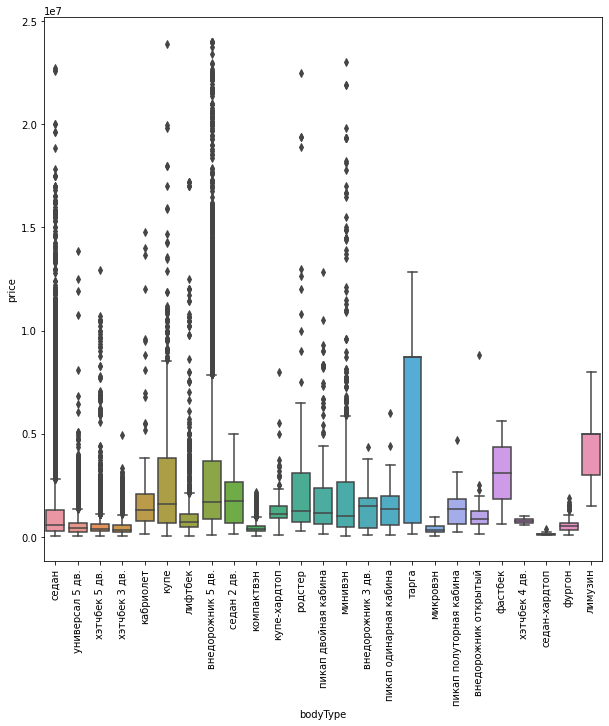

In [141]:
obj_param_describe(df[df['Train']==1],'bodyType')

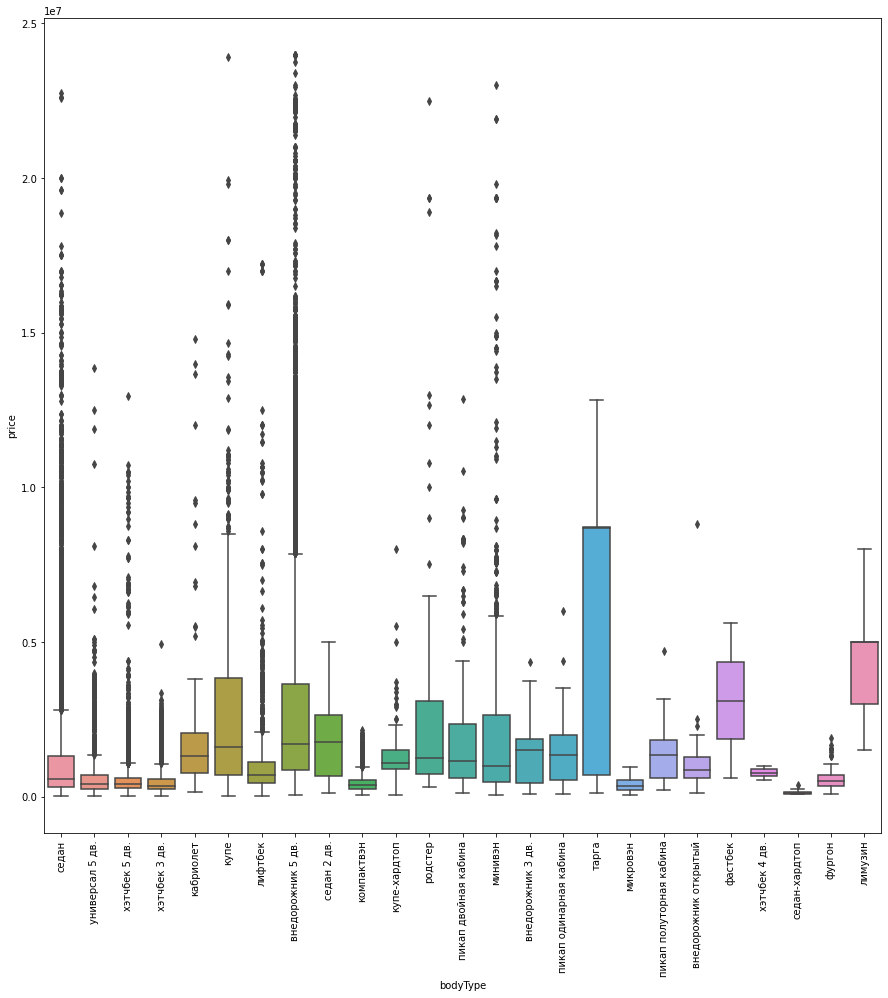

In [142]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.boxplot(x='bodyType', y='price', data=df[df['Train']==1])

Влияние типа кузова на цену тоже очевидно и наличие выбросов. Чем популярнее кузов тем больше выбросов. Лимузин самый стабильный))  
Оценим долю рынка в количественном и денежном соотнешении

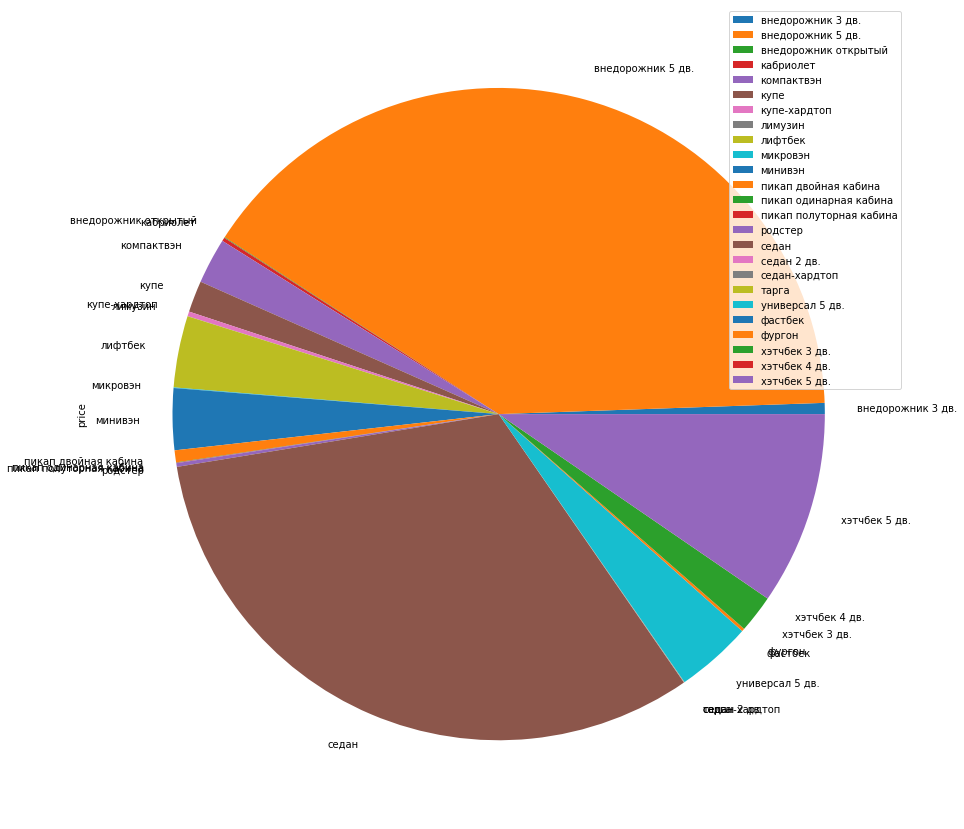

In [143]:
# доля рынка в количественном соотношении
df[df['Train']==1].groupby(['bodyType']).count().plot(kind='pie',y='price',figsize=(15,15),rot=90)

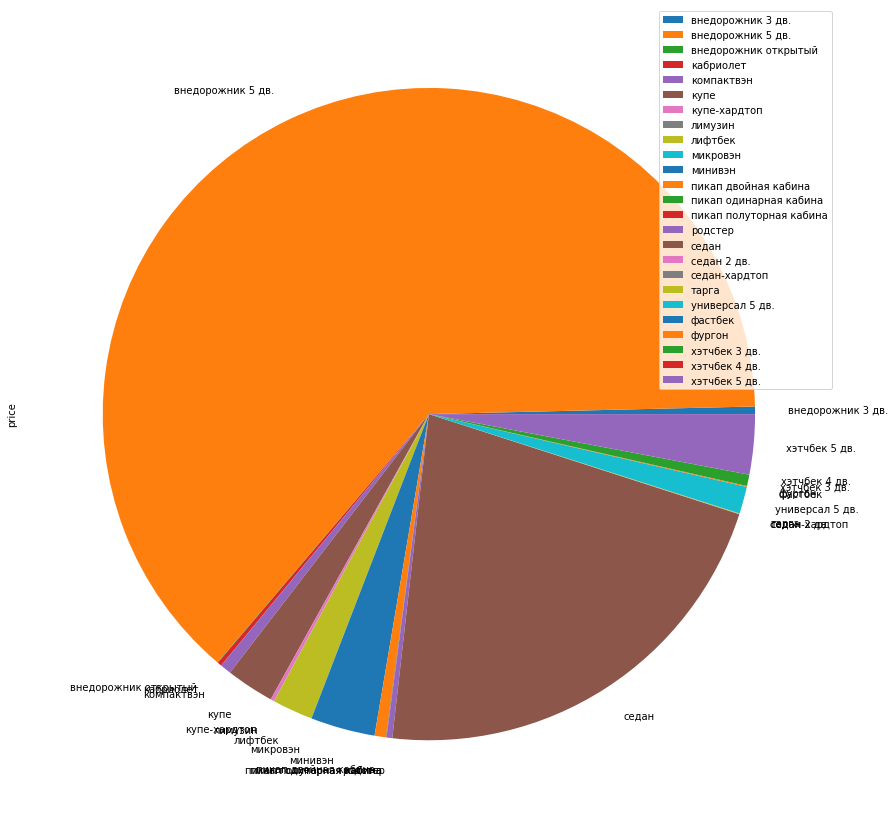

In [144]:
# доля рынка в денежном отношении
df[df['Train']==1][['bodyType','price']].groupby(['bodyType']).sum().plot(kind='pie',y='price',figsize=(15,15),rot=90)

## Вывод bodyType
Пропусков нет.  
Привели типы кузовов в трейне к такому же виду как в тесте, для этого "отрезали" модификации , т.к. по сути типы кузовов были отдни и теже  
Оценили влияние переменной на целевой признак.  
+
для себя оценили доли рынка в денежном и количественном соотношении 

## Brand

In [145]:
df[df['Train']==0].brand.value_counts()

bmw           4473
volkswagen    4404
nissan        4393
mercedes      4180
toyota        3913
audi          3421
mitsubishi    2843
skoda         2741
volvo         1463
honda         1150
infiniti       871
lexus          834
Name: brand, dtype: int64

In [146]:
df[df['Train']==1].brand.value_counts()

mercedes      9951
bmw           5853
volkswagen    4889
nissan        4290
kia           4175
hyundai       4109
audi          3431
ford          3326
toyota        3023
mitsubishi    2888
chevrolet     2617
renault       2517
skoda         2421
opel          2260
mazda         1854
volvo         1493
land_rover    1460
peugeot       1212
citroen        908
suzuki         887
honda          815
lexus          748
daewoo         673
infiniti       666
porsche        616
subaru         528
ssang_yong     464
cadillac       400
jeep           397
chery          392
mini           382
great_wall     315
dodge          306
jaguar         288
chrysler       252
geely          190
Name: brand, dtype: int64

Да, в выборке тестовой попались лишние брендцы, но они помогут выявить заивисмости по остальнеым параметрам.

доля пропусков:  0.0
Значения параметра и их количество
mercedes      9951
bmw           5853
volkswagen    4889
nissan        4290
kia           4175
hyundai       4109
audi          3431
ford          3326
toyota        3023
mitsubishi    2888
chevrolet     2617
renault       2517
skoda         2421
opel          2260
mazda         1854
volvo         1493
land_rover    1460
peugeot       1212
citroen        908
suzuki         887
honda          815
lexus          748
daewoo         673
infiniti       666
porsche        616
subaru         528
ssang_yong     464
cadillac       400
jeep           397
chery          392
mini           382
great_wall     315
dodge          306
jaguar         288
chrysler       252
geely          190
Name: brand, dtype: int64


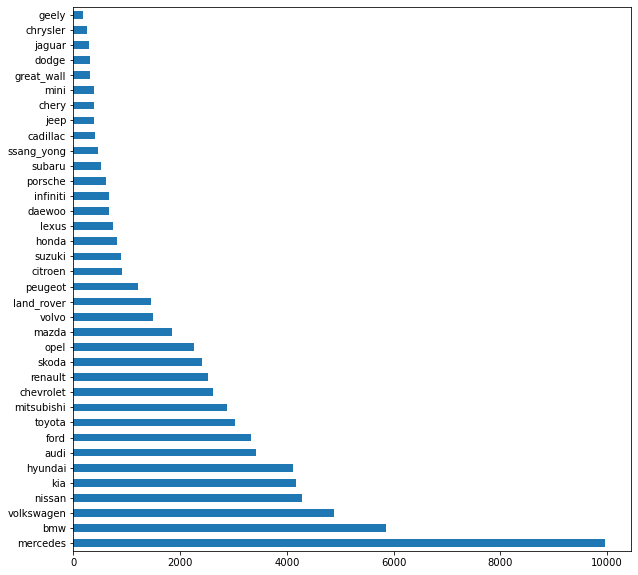

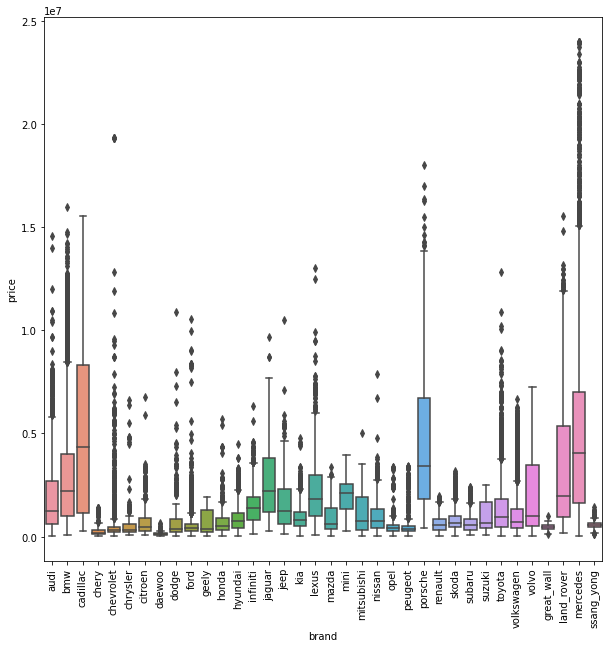

In [147]:
obj_param_describe(df[df['Train']==1],'brand')

Судя по боксплоту значение данного параметра сельно влияет на цену, оно и очевидно. Но дело в том , что дорогие бренды имеют и более широкий набор опций.  
Так же видим выбросы , что у боллее дорогих марок больше выбросомуц потому что у них есть особые модели стоящие дороги,Ю а у недорогих марок такого нет. Например : CHERY,SANG-YONG,GREAT WALL,DEWOO. Я считаю что их необходимо удалить потому что они будут только путать модель.

доля пропусков:  0.0
Значения параметра и их количество
kia           4175
hyundai       4109
ford          3326
chevrolet     2617
renault       2517
opel          2260
mazda         1854
land_rover    1460
peugeot       1212
citroen        908
suzuki         887
daewoo         673
porsche        616
subaru         528
ssang_yong     464
cadillac       400
jeep           397
chery          392
mini           382
great_wall     315
dodge          306
jaguar         288
chrysler       252
geely          190
Name: brand, dtype: int64


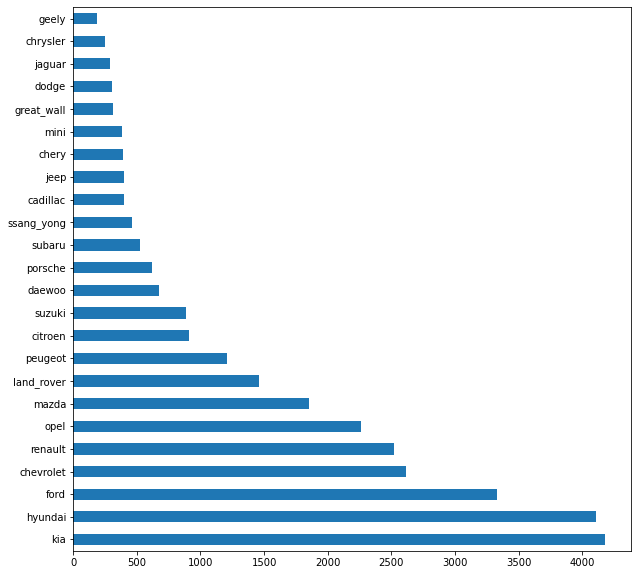

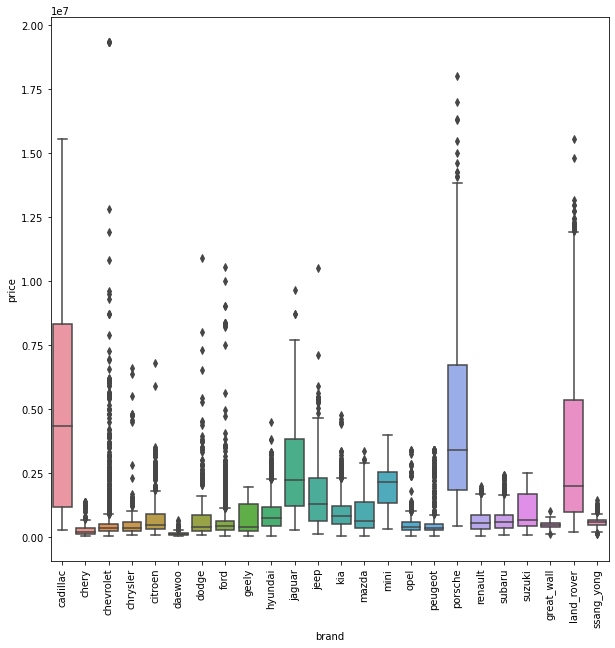

In [148]:
brands=df[df['Train']==0].brand.unique().tolist()
obj_param_describe(df[df['Train']==1].loc[~df['brand'].isin(brands)],'brand')  

In [149]:
df.loc[df['brand'].isin(['CHERY','SSANG_YONG','GREAT_WALL','DAEWOO','GEELY'])].shape

(0, 31)

In [150]:
df=df.loc[~df['brand'].isin(['CHERY','SSANG_YONG','GREAT_WALL','DAEWOO','GEELY'])]
df.shape

(105682, 31)

доля пропусков:  0.0
Значения параметра и их количество
mercedes      9951
bmw           5853
volkswagen    4889
nissan        4290
kia           4175
hyundai       4109
audi          3431
ford          3326
toyota        3023
mitsubishi    2888
chevrolet     2617
renault       2517
skoda         2421
opel          2260
mazda         1854
volvo         1493
land_rover    1460
peugeot       1212
citroen        908
suzuki         887
honda          815
lexus          748
daewoo         673
infiniti       666
porsche        616
subaru         528
ssang_yong     464
cadillac       400
jeep           397
chery          392
mini           382
great_wall     315
dodge          306
jaguar         288
chrysler       252
geely          190
Name: brand, dtype: int64


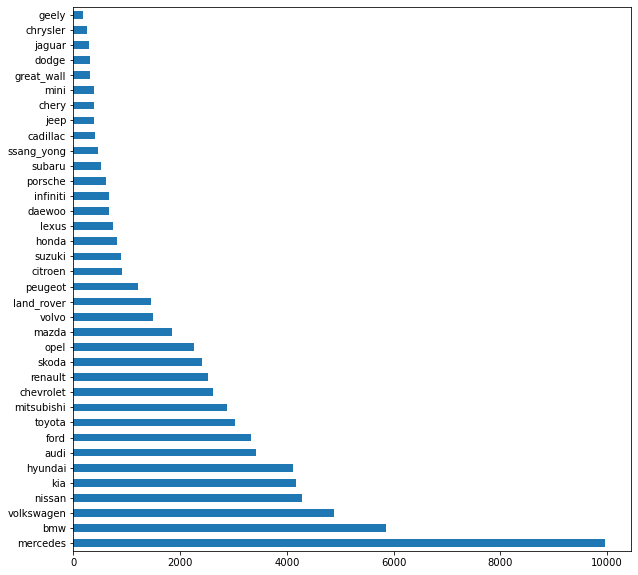

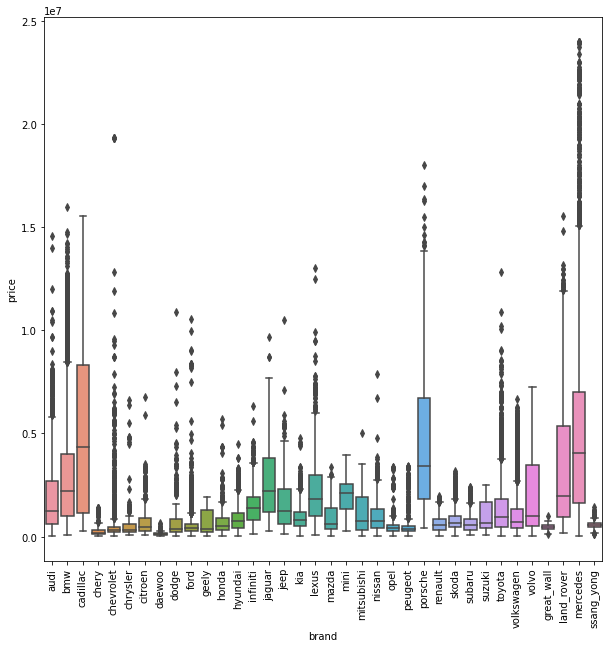

In [151]:
obj_param_describe(df[df['Train']==1],'brand')

## Вывод brand
Пропусков нет. В трейне много других брендов, дешевые из них были удалены('CHERY','SSANG_YONG','GREAT_WALL','DAEWOO','GEELY'), всего было удалено 2034 записи.  
Остальные бренды я решил оставить для информативности и наличия большего объема информации для обучения.

## color

In [152]:
df[df['Train']==0].color.isnull().sum()

0

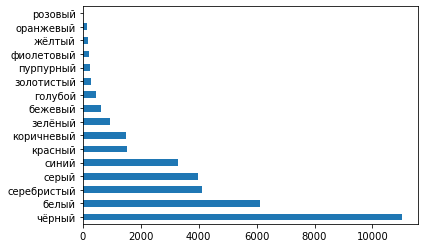

In [153]:
df[df['Train']==0].color.value_counts().plot(kind='barh')

доля пропусков:  0.0
Значения параметра и их количество
чёрный         19957
белый          12679
серый           8996
серебристый     8090
синий           7612
красный         3848
коричневый      2794
зелёный         2050
бежевый         1523
голубой         1051
жёлтый           536
золотистый       513
пурпурный        492
оранжевый        420
фиолетовый       415
розовый           20
Name: color, dtype: int64


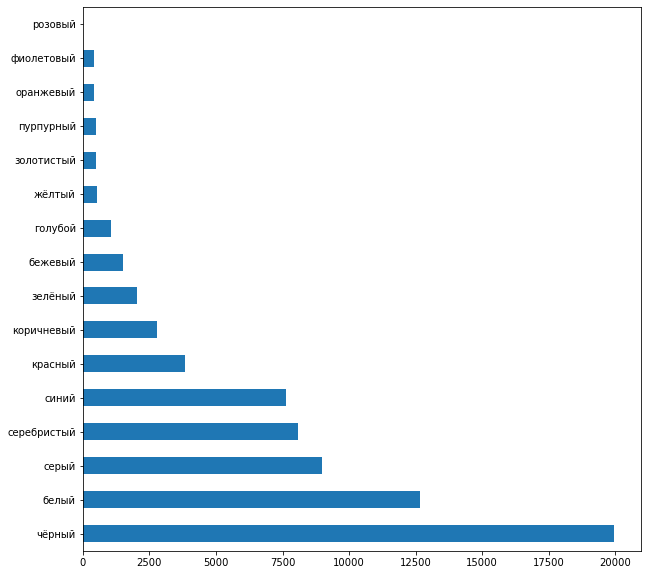

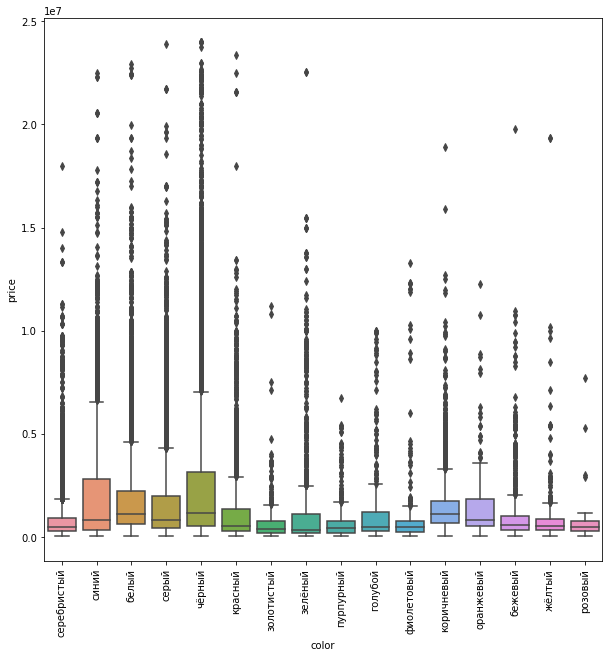

In [154]:
obj_param_describe(df[df['Train']==1],'color')

## Вывод color
Пропусков нет, пропорции по распространенности йцветов в тестовой и обучающей выборке одинаковы. Конечно построен график  зависимости цены от цвета...но это так..

## fuelType

In [155]:
df[df['Train']==0].fuelType.isna().sum()

0

In [156]:
df[df['Train']==0].fuelType.value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

доля пропусков:  0.0
Значения параметра и их количество
бензин     57731
дизель     12917
гибрид       227
электро      107
газ           14
Name: fuelType, dtype: int64


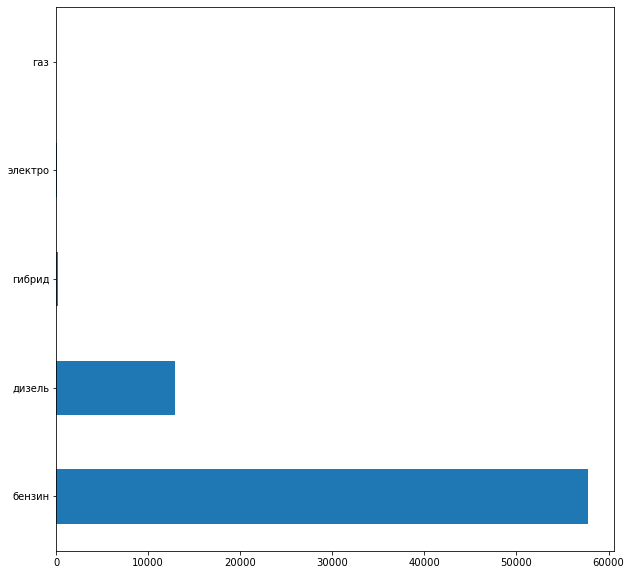

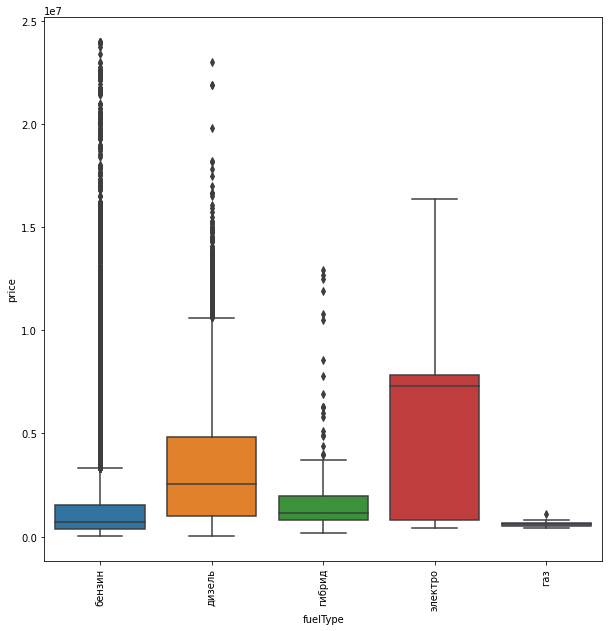

In [157]:
obj_param_describe(df[df['Train']==1],'fuelType')

## Вывод fuelType
Пропусков нет, выбросов нет.  
\Бензин самый популярный потому больше всего выбросов .  

## engineDisplacement

In [158]:
df.engineDisplacement.isna().sum()

0

In [159]:
print(df[df['Train']==0].engineDisplacement.value_counts().index.tolist())

['2.0', '1.6', '3.0', '1.8', '2.5', '2.4', '3.5', '1.4', '1.5', '1.2', '4.4', '2.8', '4.7', '1.3', '5.5', '4.0', '3.2', '4.5', '2.1', '3.7', '2.2', '4.2', '1.9', '2.3', '2.7', '3.6', '5.6', '5.0', '5.7', '2.9', '4.6', '3.1', '4.8', '1.7', '3.8', '1.0', '2.6', '', '0.7', '6.0', '3.3', '3.4', '4.1', '4.3', '5.4', '6.2', '5.2', '5.9', '6.3', '5.8', '6.6', '4.9', '1.1', '5.3', '3.9']


In [160]:
print(df[df['Train']==1].engineDisplacement.value_counts().index.tolist())

['1.6', '2.0', '1.4', '1.8', '200', '2.4', '2.5', '1.5', '2.0d', '350', '3.0d', '3.0', '300', '2.5d', '3.5', '400', '450', '220', '1.2', '30d', '2.3', '250', '1.3', '1.7', '2.2d', '63', '500', '180', '320i', '2.4d', '3.6', 'Stepway', 'Cooper', '20i', '20d', 'Long', '6.2', 'ТагАЗ', '2.7', '3.2', '45', '4.0', '4.5d', '320', '40', 'GTC', '4.4', '35i', '2.7d', '0.8', '1.9d', '6-speed', '35', '320d', '520i', '1.0', 'M50d', '2.8', '520d', '318i', '2.2', 'S', '4.2', '1.5d', '1.6d', '55', '4.4d', 'Grand', '3.8', '5.6', '40d', '530d', '230', 'Competition', '2.8d', 'Turbo', '5-speed', '5.0', '4.7', '3.7', '318d', '4-speed', '280', '525i', '528i', '110', 'XL', '570', '560', '40i', '116i', '30i', 'Supercharged', 'X-Line', '730Ld', '4.6', '5.7', '18d', '3.6d', '530i', 'FX35', '3.0i', '240', '28i', '316i', '5.3', '3.3', '25d', '1.9', '3.2d', '750Li', 'John', 'AMT', '460', '600', '218i', '18i', '523i', 'Classic', 'Diesel', '1.8d', '3.1', '0.7', 'GTS', '270', '1.1', 'DSG7', '1.3d', '118i', '43', 'DSG'

При извлечении возникола проблема. Это могла быть и ошибка при сборе данных и ошибки пользователей при заполнении

In [161]:
df[['name','engineDisplacement']][df['engineDisplacement']=='Brawny']

,name,engineDisplacement
30624,Brawny 2.0d AT (86 л.с.) 4WD,Brawny


Данные можно найти в параметре name, извлечем при помощи регулячярок

In [162]:
re.findall('\d+\.\d+','Brawny 2.0d AT (86 л.с.) 4WD')[0]

'2.0'

In [163]:
error_list_str=[]
def find_Displacement(name):
    try:
        return float(re.findall('\d+\.\d+',name)[0])
    except:
        error_list_str.append(name)
        return float(0)

In [164]:
df['engineDisplacement']=df['name'].apply(lambda x:find_Displacement(x))

In [165]:
print(df[df['Train']==1].engineDisplacement.value_counts().index.tolist())

[2.0, 1.6, 3.0, 1.4, 1.8, 2.5, 2.4, 1.5, 3.5, 2.9, 1.3, 2.2, 2.3, 4.4, 4.0, 1.2, 1.7, 2.7, 3.6, 3.2, 2.1, 5.5, 2.8, 4.7, 6.2, 4.5, 5.0, 4.2, 1.9, 4.8, 3.7, 5.7, 0.8, 1.0, 3.8, 4.6, 5.6, 0.0, 3.3, 5.3, 6.0, 0.7, 2.6, 3.1, 1.1, 5.4, 4.3, 4.1, 3.4, 5.2, 6.4, 5.9, 4.9, 5.8, 6.6, 6.1, 6.8, 6.5, 3.9, 6.3, 6.7, 7.0, 7.7, 8.1, 7.2, 7.3, 7.4, 7.5, 8.2]


In [166]:
df[df['Train']==1].head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,Train,sell_id,log_diffDate,log_enginePower,annual_mileage,Guarantee
0,седан,audi,серебристый,бензин,1982,1.8 MT (90 л.с.),4.0,1984,SEDAN MECHANICAL 1.8,механическая,1.8,90,NaN,300000,{'id': '0'},передний,Левый,NaN,2.0,Оригинал,True,NaN,100000.0,2020-11-29,100,1,0,1.098612,4.51086,8333.33,False
1,седан,audi,синий,бензин,1988,2.0 MT (115 л.с.),4.0,1989,SEDAN MECHANICAL 2.0,механическая,2.0,115,"Рассмотрю обмен.Машина в достойном состоянии,н...",150000,{'id': '0'},передний,Левый,NaN,3.0,Дубликат,True,NaN,90000.0,2020-11-15,100,1,0,0.693147,4.75359,4838.71,False


In [167]:
set(error_list_str)

{'250 e Electro AT (132 кВт)',
 '30kWh Electro AT (81 кВт)',
 '4S Electro AT (391 кВт) 4WD',
 '55 Electro AT (301 кВт) 4WD',
 '94Ah Electro AT (126 кВт)',
 'EV Electro AT (106 кВт)',
 'Electro AT (111 кВт)',
 'Electro AT (126 кВт)',
 'Electro AT (148 кВт)',
 'Electro AT (173 кВт) 4WD',
 'Electro AT (50 кВт)',
 'Electro AT (81 кВт)',
 'Electro AT (9 кВт)',
 'S Electro AT (136 кВт)',
 'Turbo Electro AT (501 кВт) 4WD',
 'Turbo S Electro AT (561 кВт) 4WD',
 'e-Golf Electro AT (85 кВт)'}

Отдельными у нас остались только электромобили. Извлечем мощность в кВт

In [168]:
df['electro_eD']=0
num_cols.append('electro_eD')

In [169]:
float(re.findall('(\d+) кВт','250 e Electro AT (132 кВт)')[0])

132.0

In [170]:
def find_electro_eD(name):
    try:
        return float(re.findall('(\d+) кВт',name)[0])
    except:
        
        return float(0)
df['electro_eD']=df['name'].apply(lambda x:find_electro_eD(x))

In [171]:
df.electro_eD.value_counts()

0.0      105520
81.0         72
301.0        44
126.0        12
561.0         6
501.0         5
111.0         4
85.0          4
50.0          3
173.0         3
391.0         3
136.0         2
148.0         1
9.0           1
106.0         1
132.0         1
Name: electro_eD, dtype: int64

In [172]:
df[df['electro_eD']!=0].head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Состояние,owners,ПТС,Таможня,Владение,price,start_date,model_name,Train,sell_id,log_diffDate,log_enginePower,annual_mileage,Guarantee,electro_eD
2412,внедорожник 5 дв.,audi,синий,электро,2018,55 Electro AT (301 кВт) 4WD,5.0,2020,ALLROAD_5_DOORS AUTOMATIC 55,автоматическая,0.0,408,Новый дилерский центр Ауди в Москве.\n\nУникал...,0,"{'id': '22291467', 'name': 'Sport 55 quattro',...",полный,Левый,NaN,0.0,Оригинал,True,NaN,7303159.0,2020-09-15,E_TRON,1,0,1.098612,6.013715,0.0,True,301.0
2413,внедорожник 5 дв.,audi,чёрный,электро,2018,55 Electro AT (301 кВт) 4WD,5.0,2020,ALLROAD_5_DOORS AUTOMATIC 55,автоматическая,0.0,408,Новый дилерский центр Ауди в Москве.\n\nУникал...,0,"{'id': '22291462', 'name': 'Design 55 quattro'...",полный,Левый,NaN,0.0,Оригинал,True,NaN,7610099.0,2020-09-15,E_TRON,1,0,1.098612,6.013715,0.0,True,301.0


In [173]:
df['electro_eD'] = pd.to_numeric(df['electro_eD'], downcast="float")

доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 1.8 
 медиана: 2.0 
 среднее: 2.402 
 max : 6.6 
 75-й перцентиль: 3.0 
 IQR: 1.2 
 Границы выбросов: [0.0, 4.8] 
 Доля выбросов: 0.03



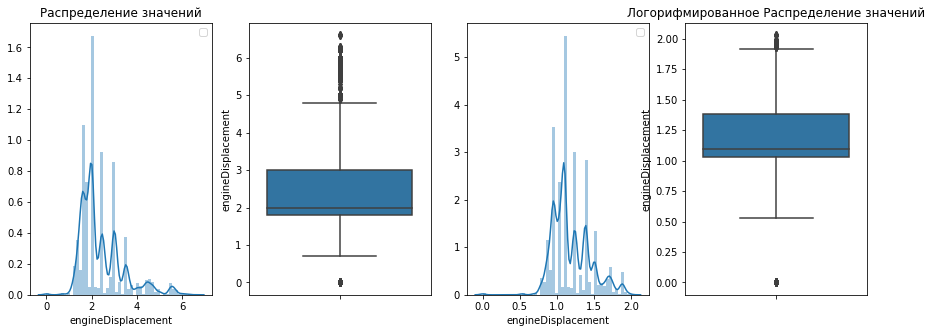

In [174]:
num_describer(df[df['Train']==0],'engineDisplacement')

доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 1.6 
 медиана: 2.0 
 среднее: 2.231 
 max : 8.2 
 75-й перцентиль: 2.5 
 IQR: 0.8999999999999999 
 Границы выбросов: [0.25, 3.85] 
 Доля выбросов: 0.0661



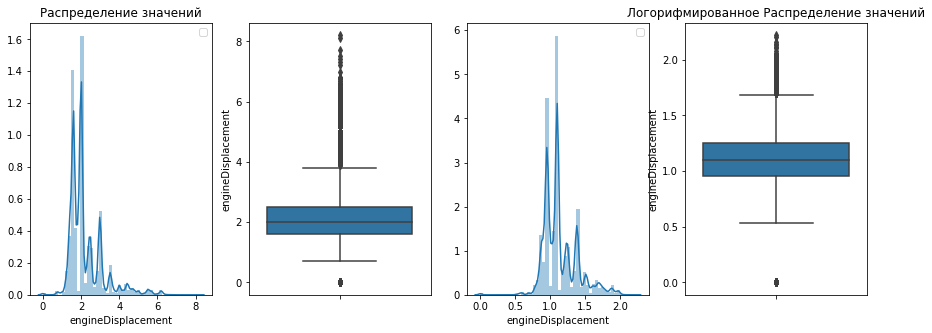

In [175]:
num_describer(df[df['Train']==1],'engineDisplacement')

распределение больше похоже на логнормальное, разрывы очевидны из-за фиксированных знеачений объема. я решил сделоать данный параметр линейным чтобы была возможна операция сравнения. К сожалению статистики не сильно релевантны по данному параметру.

In [176]:
df.electro_eD.describe()

count    105682.000000
mean          0.281524
std           8.967197
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         561.000000
Name: electro_eD, dtype: float64

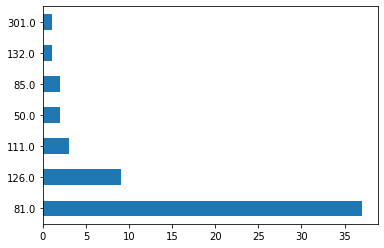

In [177]:
df[(df['Train']==0)&(df['electro_eD']!=0)].electro_eD.value_counts().plot(kind='barh')

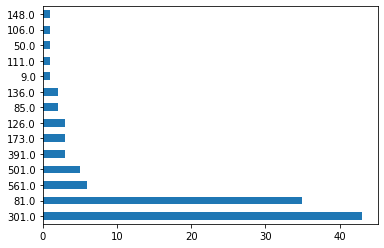

In [178]:
df[(df['Train']==1)&(df['electro_eD']!=0)].electro_eD.value_counts().plot(kind='barh')

Для электромобилей данный параметр тоже вышел не очень релевантным

In [179]:
num_cols.append('engineDisplacement')
num_cols.append('electro_eD')

## Вывод engineDisplacement
Пропусков нет.  
Выбросы есть но это нормально т.к. у нас больше распространены машины с двигателем ~2литра и 6литровые будут выбросом. Электромобили выделены в отдельный показатель electro_eD.  
Распределение похоже на логнормальное, но т.к. рлказатьель не совсем линейный и есть фиксированные значения, в линейный он преобразован для возможность применения операции сравнения.

## Name

In [180]:
df[['name','engineDisplacement','vehicleTransmission','enginePower','Привод','fuelType','model_name']]

,name,engineDisplacement,vehicleTransmission,enginePower,Привод,fuelType,model_name
0,1.8 MT (90 л.с.),1.8,механическая,90,передний,бензин,100
1,2.0 MT (115 л.с.),2.0,механическая,115,передний,бензин,100
2,2.0 MT (112 л.с.),2.0,механическая,112,передний,бензин,100
3,2.3 AT (133 л.с.),2.3,автоматическая,133,передний,бензин,100
4,2.3 MT (133 л.с.),2.3,механическая,133,передний,бензин,100
...,...,...,...,...,...,...,...
106017,316i 1.6 AT (136 л.с.),1.6,автоматическая,136,задний,бензин,3ER
106018,520d xDrive 2.0d AT (190 л.с.) 4WD,2.0,автоматическая,190,полный,дизель,5ER
106019,523i 2.5 AT (170 л.с.),2.5,автоматическая,170,задний,бензин,5ER
106020,20d 2.0d AT (184 л.с.) 4WD,2.0,автоматическая,184,полный,дизель,X1


В поле name зашифрованы другие показатели. Отличие только для марок BMW , Mercedec т.к. там для них указаны модификации

In [181]:
df.loc[106018]

bodyType                                             седан
brand                                                  bmw
color                                               чёрный
fuelType                                            дизель
modelDate                                             2016
name                    520d xDrive 2.0d AT (190 л.с.) 4WD
numberOfDoors                                            4
productionDate                                        2018
vehicleConfiguration                   SEDAN AUTOMATIC 2.0
vehicleTransmission                         автоматическая
engineDisplacement                                       2
enginePower                                            190
description                 Продаётся отличный автомобиль.
mileage                                              98000
complectation_dict                                     NaN
Привод                                              полный
Руль                                                 Лев

Потому я принял решение удалить данный параметр

In [182]:
df=df.drop(['name'],axis='columns')

In [183]:
cat_cols.remove('name')

## Вывод name
т.к. информация, содержащаяся в данном показателе содержалась в других колонках признак был удален

# vehicleConfiguration

In [184]:
df.vehicleConfiguration.isna().sum()

0

In [185]:
df[['vehicleConfiguration','bodyType','engineDisplacement','vehicleTransmission']]

,vehicleConfiguration,bodyType,engineDisplacement,vehicleTransmission
0,SEDAN MECHANICAL 1.8,седан,1.8,механическая
1,SEDAN MECHANICAL 2.0,седан,2.0,механическая
2,SEDAN MECHANICAL 2.0,седан,2.0,механическая
3,SEDAN AUTOMATIC 2.3,седан,2.3,автоматическая
4,SEDAN MECHANICAL 2.3,седан,2.3,механическая
...,...,...,...,...
106017,SEDAN AUTOMATIC 1.6,седан,1.6,автоматическая
106018,SEDAN AUTOMATIC 2.0,седан,2.0,автоматическая
106019,SEDAN AUTOMATIC 2.5,седан,2.5,автоматическая
106020,ALLROAD_5_DOORS AUTOMATIC 2.0,внедорожник 5 дв.,2.0,автоматическая


Все аналогично признаку name

In [186]:
df=df.drop(['vehicleConfiguration'],axis='columns')

In [187]:
cat_cols.remove('vehicleConfiguration')

## Вывод vehicleConfiguration
удален

## vehicleTransmission

In [188]:
df.vehicleTransmission.isna().sum()

0

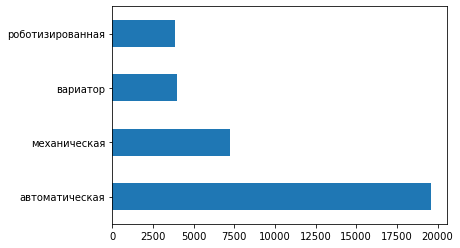

In [189]:
df[df['Train']==0].vehicleTransmission.value_counts().plot(kind='barh')

доля пропусков:  0.0
Значения параметра и их количество
автоматическая      40046
механическая        18927
роботизированная     7029
вариатор             4994
Name: vehicleTransmission, dtype: int64


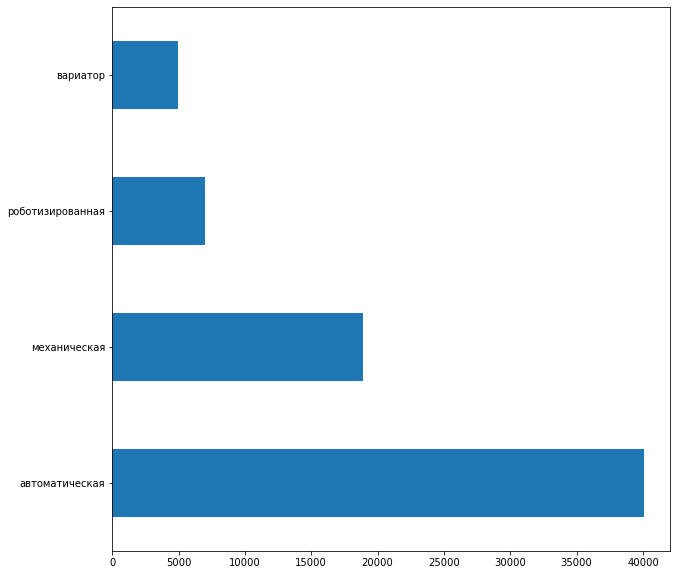

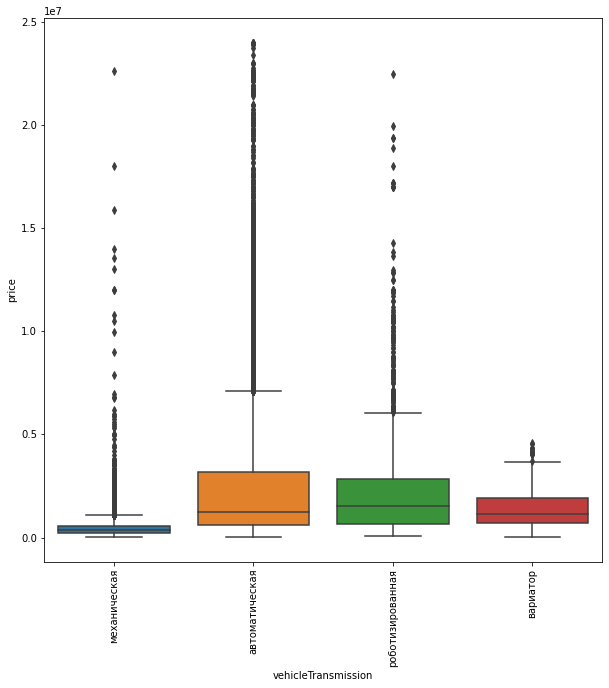

In [190]:
obj_param_describe(df[df['Train']==1],'vehicleTransmission')

Пропусков нет. Немного изменилисмсь пропорции по распространенности роботизированной коробки и вариатора.

## Вывод vehicleTransmission


## Привод

In [191]:
df[df['Train']==0].Привод.isna().sum()

0

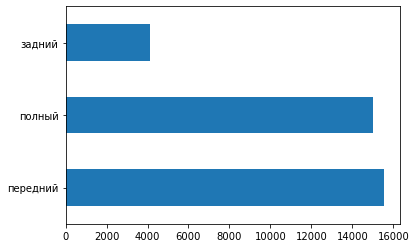

In [192]:
df[df['Train']==0].Привод.value_counts().plot(kind='barh')

доля пропусков:  0.0
Значения параметра и их количество
передний    34718
полный      30781
задний       5497
Name: Привод, dtype: int64


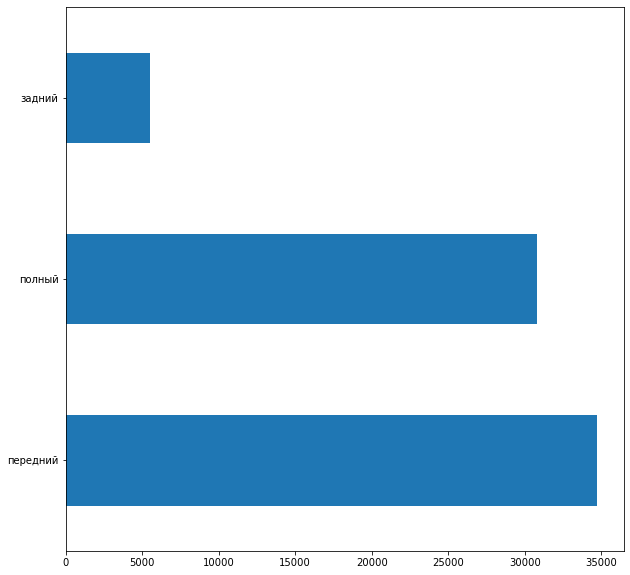

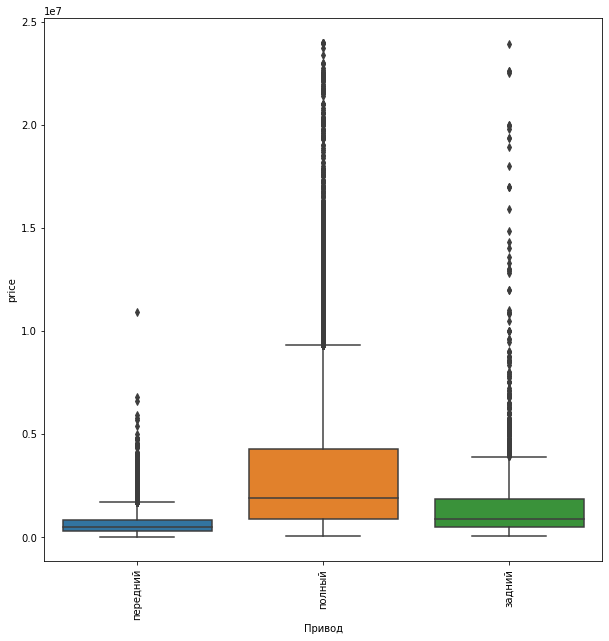

In [193]:
obj_param_describe(df[df['Train']==1],'Привод')

## Вывод Привод
Пропусков нет,Выбросов нет, исходя из боксплота значение признако имеет значимость для цены

## Руль

In [194]:
df.Руль.isna().sum()

0

In [195]:
df.Руль.value_counts()

Левый     102935
Правый      2747
Name: Руль, dtype: int64

доля пропусков:  0.0
Значения параметра и их количество
Левый     69648
Правый     1348
Name: Руль, dtype: int64


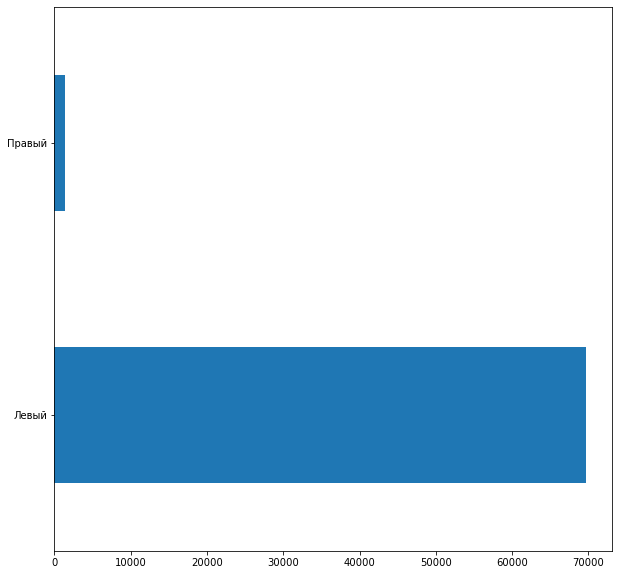

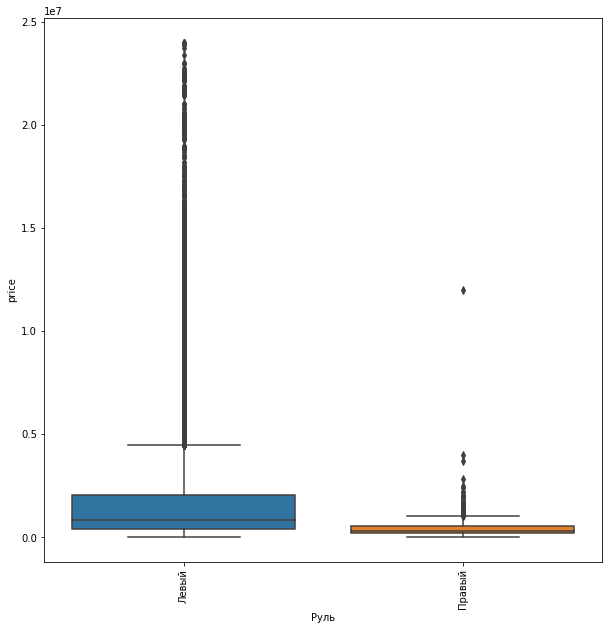

In [196]:
obj_param_describe(df[df['Train']==1],'Руль')

## Вывод Руль
Пропусков нет, выбросов нет. распределение значений - очевидно.

## ПТС

In [197]:
df[df['Train']==0].ПТС.isna().sum()

1

In [198]:
df[df['Train']==1].ПТС.isna().sum()

422

доля пропусков:  0.00594399684489267
Значения параметра и их количество
Оригинал    63061
Дубликат     7513
Name: ПТС, dtype: int64


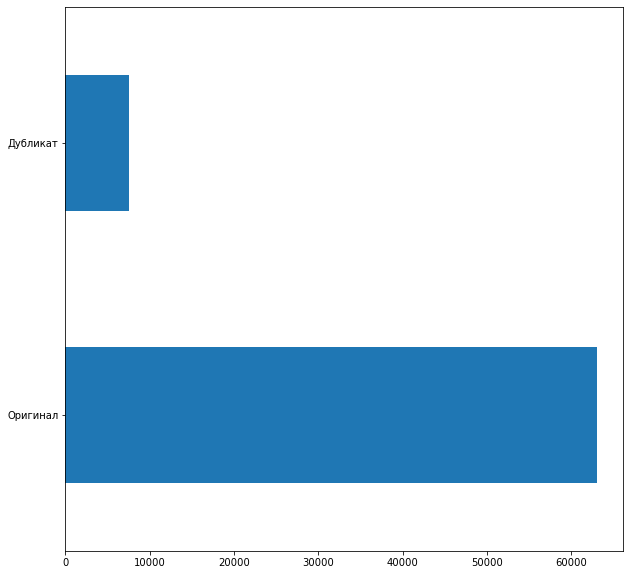

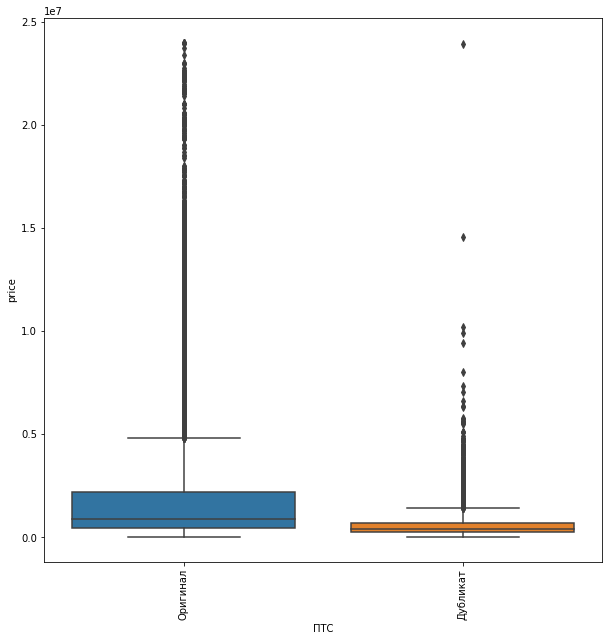

In [199]:
obj_param_describe(df[df['Train']==1],'ПТС')

In [200]:
df['ПТС']=df['ПТС'].fillna('Оригинал')

## Вывод ПТС
Выбросов нет. Пропуски были - 421 шт(0.6%) заполнены самы популярным значением -"оригинал"

## Таможня

In [201]:
df[df['Train']==0].Таможня.isna().sum()

0

In [202]:
df[df['Train']==1].Таможня.isna().sum()

0

доля пропусков:  0.0
Значения параметра и их количество
True    70996
Name: Таможня, dtype: int64


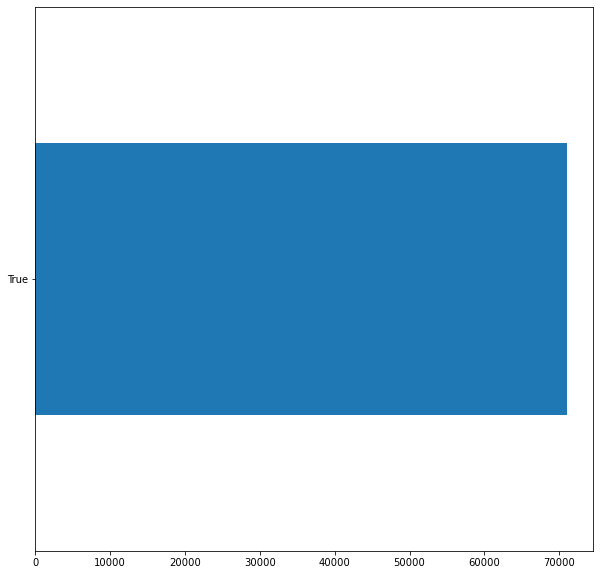

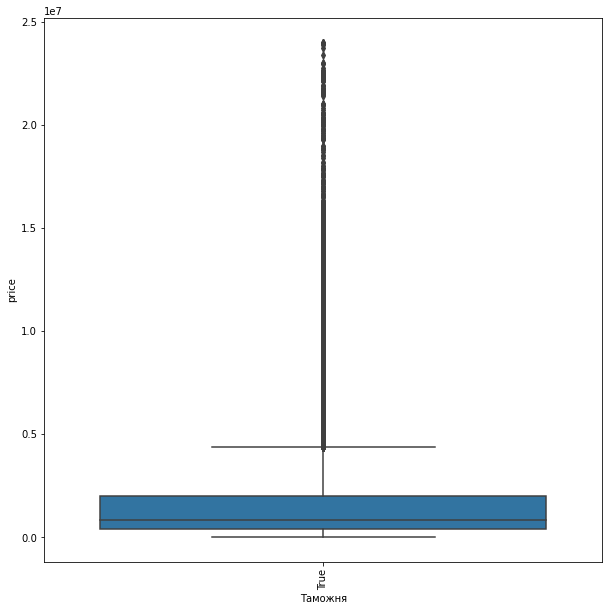

In [203]:
obj_param_describe(df[df['Train']==1],'Таможня')

In [204]:
#т.к. у всех авто признак имеет одинаковое значение то он неинформативен, удалим
df=df.drop(['Таможня'],axis='columns')

## Вывод Таможня
Во всейц выборке одно значение, потому не информативен потому удален

## Владение

In [205]:
print(df[df['Train']==0].shape[0])
print(df[df['Train']==0].Владение.isna().sum())
print(df[df['Train']==0].Владение.isna().sum()/df[df['Train']==0].shape[0])

34686
22691
0.6541832439600992


In [206]:
df[df['Train']==0].Владение.value_counts()

1 год и 10 месяцев     209
2 года                 197
1 год                  194
1 год и 1 месяц        193
1 год и 2 месяца       187
                      ... 
22 года и 9 месяцев      1
19 лет                   1
26 лет и 3 месяца        1
18 лет и 7 месяцев       1
17 лет и 9 месяцев       1
Name: Владение, Length: 275, dtype: int64

In [207]:
print(df[df['Train']==1].shape[0])
print(df[df['Train']==1].Владение.isna().sum())
print(df[df['Train']==1].Владение.isna().sum()/df[df['Train']==1].shape[0])

70996
52700
0.7422953405825681


In [208]:
df[df['Train']==1].Владение.value_counts()

{'year': 2018, 'month': 11}    339
{'year': 2018, 'month': 12}    314
{'year': 2019, 'month': 8}     301
{'year': 2018, 'month': 10}    298
{'year': 2019, 'month': 11}    285
                              ... 
{'year': 2001, 'month': 9}       1
{'year': 2002, 'month': 8}       1
{'year': 1989, 'month': 12}      1
{'year': 1997, 'month': 7}       1
{'year': 1998, 'month': 7}       1
Name: Владение, Length: 290, dtype: int64

Много пропуксков. В трейне и тесте данные представлены в разных форматах, надо ривести к одному виду.

In [209]:
#заполняем пропуски значением nodata
df['Владение'] = df['Владение'].fillna('nodata')

In [210]:
df['Владение'].value_counts()

nodata                         75391
{'year': 2018, 'month': 11}      339
{'year': 2018, 'month': 12}      314
{'year': 2019, 'month': 8}       301
{'year': 2018, 'month': 10}      298
                               ...  
19 лет и 5 месяцев                 1
19 лет и 4 месяца                  1
18 лет и 5 месяцев                 1
{'year': 1997, 'month': 7}         1
{'year': 1996, 'month': 7}         1
Name: Владение, Length: 566, dtype: int64

In [211]:
def extract_months(months):
    if months == 1:
        return f'{months} месяц'
    elif 2 <= months <= 4:
        return f'{months} месяца'
    else:
        return f'{months} месяцев'

def extract_year(years):
    if 11 <= years <= 14 or 5 <= years%10 <= 9 or years%10 == 0:
        return f'{years} лет'
    elif years%10 == 1:
        return f'{years} год'
    elif 2 <= years%10 <= 4:
        return f'{years} годa'

In [212]:
a="{'year': 1977, 'month': 12} "
row = re.findall('\d+',a)
row

['1977', '12']

In [213]:
def extract(row):
    row = re.findall('\d+',row)
    if row != []:
        years = 2020 - int(row[0])-1

        try:
            months = 12 - int(row[1])
        except:
            months=0
        if years < 0:
            return extract_months(int(row[1]))
        elif years == 0 and months < 12:
            return extract_months(months)
        elif years >= 0 and months == 12:
            return extract_year(years + 1)
        elif years >= 0 and months > 12:
            return extract_year(years + 1)+' и '+extract_months(months - 12)
        elif years > 0 and months < 12:
            return extract_year(years)+' и '+extract_months(months)
        return 'nodata'

In [214]:
df.loc[df['Train']==1,'Владение'] = df[df['Train']==1]['Владение'].apply(extract)

In [215]:
df.Владение.isna().sum()

52700

In [216]:
df['Владение'] = df['Владение'].fillna('nodata')

In [217]:
print(df.shape[0])
#print(df.Владение.isna().sum())
print(df.Владение.isna().sum()/df[df['Train']==1].shape[0])

105682
0.0


In [218]:
df[df['Train']==1]['Владение'].value_counts(normalize=True)[:10]

nodata       0.742295
1 месяц      0.007874
3 месяца     0.006493
6 месяцев    0.006451
2 месяца     0.006324
4 месяца     0.005648
7 месяцев    0.005578
5 месяцев    0.005536
8 месяцев    0.005423
9 месяцев    0.005141
Name: Владение, dtype: float64

In [219]:
df[df['Train']==1]['Владение'].value_counts(normalize=True)[-10:]

17 лет и 4 месяца      0.000014
22 годa и 4 месяца     0.000014
22 годa и 5 месяцев    0.000014
19 лет и 6 месяцев     0.000014
45 лет и 3 месяца      0.000014
21 год и 5 месяцев     0.000014
30 лет и 7 месяцев     0.000014
23 годa и 5 месяцев    0.000014
16 лет и 10 месяцев    0.000014
29 лет и 1 месяц       0.000014
Name: Владение, dtype: float64

Продажа автомобиля после 1 одного месяца владения считаю очень подощрительным, да и после 2-3 тоже. Считаю что эт возможно пекрекупы , которые нас опредили)) таких около20%
Выделю их в отдельный признак.

In [220]:
def to_months(row):
    if pd.notnull(row) and row!='nodata':
        owners = row.split(' ')
        if len(owners) == 2:
            if owners[1] in ['год', 'года', 'лет']:
                months=int(owners[0])*12
                return months
            else:
                return int(owners[0])
        else:
            return int(owners[0])*12 + int(owners[3])

In [221]:
df['ownership'] = df['Владение'].apply(to_months)
df=df.drop(['Владение'],axis='columns')
num_cols.append('ownership')

In [222]:
df['ownership']=df['ownership'].fillna(0)

In [223]:
def reseller_search(num):
    if pd.notnull(num):
            if (num >0)and (num <= 3):
                return 1
            else:
                return 0
    else:
        return None

df['reseller']=df['ownership'].apply(reseller_search)


In [224]:
df['reseller']=df['reseller'].fillna(0)

доля пропусков:  0.0
Значения параметра и их количество
0    69527
1     1469
Name: reseller, dtype: int64


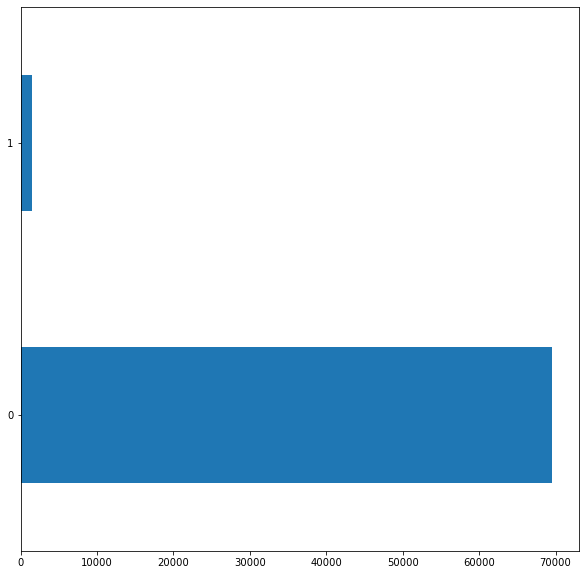

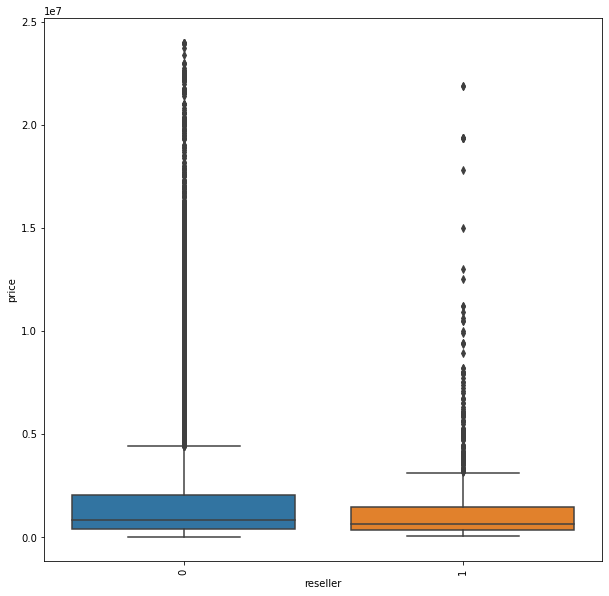

In [225]:
obj_param_describe(df[df['Train']==1],'reseller')

доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 19.001 
 max : 514.0 
 75-й перцентиль: 24.0 
 IQR: 24.0 
 Границы выбросов: [-36.0, 60.0] 
 Доля выбросов: 0.1222



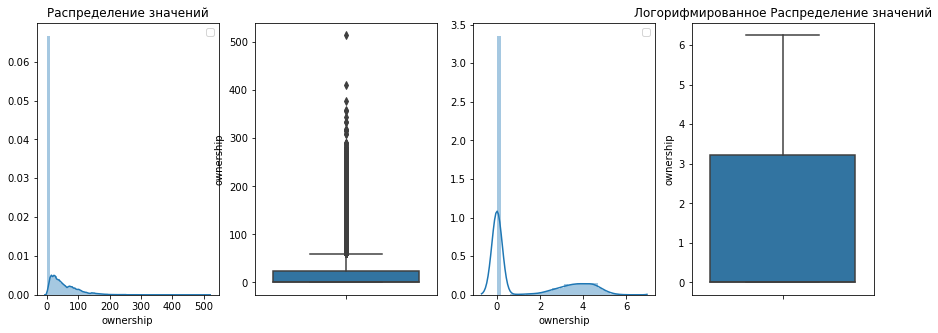

In [226]:
##int(re.findall('(\d) месяц\w+','6 месяцев')[0
num_describer(df[df['Train']==0],'ownership')

доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 11.311 
 max : 918.0 
 75-й перцентиль: 1.0 
 IQR: 1.0 
 Границы выбросов: [-1.5, 2.5] 
 Доля выбросов: 0.24



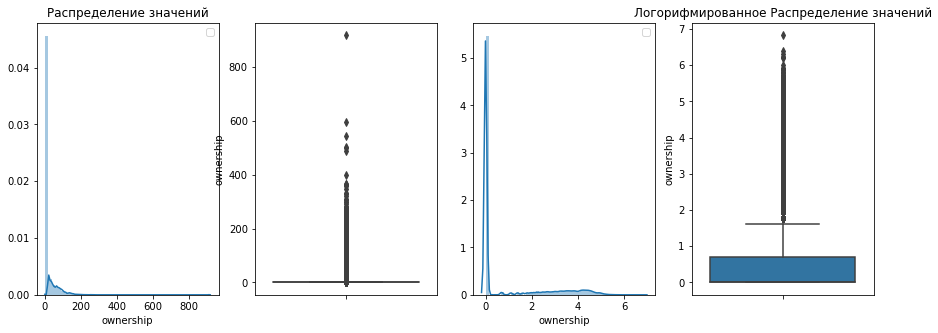

In [227]:
num_describer(df[df['Train']==1],'ownership')

In [228]:
df['log_ownership']=np.log(df['ownership']+1)
num_cols.append('log_ownership')
df=df.drop(['ownership'],axis='columns')

## Вывод Владение
Приведено было к одному виду и срок владения переведен в месяцы, на основе этого был сгенерирован признак ownership.
Так же был сгенерирован признак reseller, подразумевающий перекупов или неполадки с автомобилем.

## model_name

In [229]:
print('пропусков ',df[df['Train']==0].model_name.isna().sum())
print('уникальных значений',len(df[df['Train']==0].model_name.unique()))

пропусков  0
уникальных значений 544


In [230]:
print('пропусков ',df[df['Train']==1].model_name.isna().sum())
print('уникальных значений',len(df[df['Train']==1].model_name.unique()))

пропусков  0
уникальных значений 1060


In [231]:
len(df.model_name.unique())

1081

In [232]:
#посмотрим топ 20 самых встречаемых значений теста
df[df['Train']==0].model_name.value_counts()[:20]

OCTAVIA         1418
5ER             1026
LANCER           855
E_KLASSE         809
PASSAT           782
A6               757
3ER              752
POLO             724
CAMRY            709
X5               675
X_TRAIL          654
A4               626
QASHQAI          609
S_KLASSE         549
OUTLANDER        544
LAND_CRUISER     514
ALMERA           502
TIGUAN           491
TOUAREG          469
COROLLA          456
Name: model_name, dtype: int64

In [233]:
#посмотрим топ 20 самых встречаемых значений трейна
df[df['Train']==1].model_name.value_counts()[-20:]

CAROL               1
SIMPLEX             1
WILL_CYPHA          1
VAMOS               1
Z3M                 1
MR_S                1
MONTE_CARLO         1
AVANTIME            1
300ZX               1
924                 1
K3                  1
PRAIRIE             1
SLR_KLASSE          1
STEALTH             1
1007                1
TACUMA              1
CROSSROAD           1
LEGACY_LANCASTER    1
ARIES               1
21                  1
Name: model_name, dtype: int64

In [234]:
uniq=df[df['Train']==0].model_name.unique().tolist()
df[(df['Train']==1)&(df['model_name'].isin(uniq))].model_name.value_counts()[:20]

E_KLASSE            1702
3ER                 1100
OCTAVIA             1049
OUTLANDER            961
5ER                  930
POLO                 925
X_TRAIL              899
PASSAT               853
GLE_KLASSE           851
QASHQAI              787
X5                   785
A4                   757
GLE_KLASSE_COUPE     756
GLC_KLASSE           740
S_KLASSE             666
TIGUAN               638
C_KLASSE             634
A6                   597
LANCER               594
X6                   586
Name: model_name, dtype: int64

## complectationDict

In [235]:
df[df['Train']==0].complectation_dict.isna().sum()/df[df['Train']==0].shape[0]

0.8149685752176671

In [236]:
df[df['Train']==1].complectation_dict.isna().sum()/df[df['Train']==1].shape[0]

0.0

In [237]:
df[(df['Train']==1)&(df['complectation_dict']=="{'id': '0'}")].shape[0]/df[df['Train']==1].shape[0]

0.645656093301031

In [238]:
df=df.drop(['complectation_dict'],axis='columns')

## Вывод complectation_dict
в тесте доля пропусков 81%,в трейне - 64%,из-за обилия пропусков признак удален

## description

In [239]:
df.description.isna().sum()

2796

In [240]:
df['description'].loc[1]

'Рассмотрю обмен.Машина в достойном состоянии,но и не без проблем конечно,плавают обороты иногда,заменить пару лампочек,документы все птс стс,приезжайте смотрите.'

In [241]:
line ='Рассмотрю обмен.Машина в достойном состоянии,но и не без проблем конечно,плавают обороты иногда,заменить пару лампочек,документы все птс стс,приезжайте смотрите.'
line=line.replace(',',' ')
line

'Рассмотрю обмен.Машина в достойном состоянии но и не без проблем конечно плавают обороты иногда заменить пару лампочек документы все птс стс приезжайте смотрите.'

In [242]:
df['description'] = df['description'].fillna(' ')
df['description'] = df['description'].apply(lambda x: x.replace(',',' '))
df['description'] = df['description'].apply(lambda x: x.replace('.',' '))
df['description'] = df['description'].apply(lambda x: x.replace(':',' '))
df['description'] = df['description'].apply(lambda x: [str(i).lower() for i in x.split()])
df['description']

0                                                        []
1         [рассмотрю, обмен, машина, в, достойном, состо...
2         [авто, на, ходу, состояние, сел, и, поехал, на...
3         [добрый, день, всем, продаю, ауди, 100, в, иде...
4         [перед, тем, как, звонить, дочитайте, до, конц...
                                ...                        
106017    [продается, bmw, 316i, в, отличном, состоянии,...
106018                    [продаётся, отличный, автомобиль]
106019                                 [хорошее, состояние]
106020    [автомобиль, в, идеальном, состоянии, куплен, ...
106021    [пробег, реальный, состояние, отличное!, автор...
Name: description, Length: 105682, dtype: object

In [243]:
df['description'].loc[99671]

['авто',
 'приобретался',
 'в',
 'рольфе',
 'по',
 'трейд-ин',
 'по',
 'факту',
 '2',
 'владельца',
 '(в',
 'птс',
 '3)',
 'кроме',
 'небольших',
 'касательных',
 'притертостей',
 '(все',
 'есть',
 'на',
 'фото)',
 'авто',
 'вложений',
 'не',
 'требует',
 'зимняя',
 'шипованная',
 'резина',
 'на',
 'дисках',
 'в',
 'подарок',
 'комплектация',
 'ultimate',
 'разумный',
 'торг',
 'на',
 'месте',
 'на',
 'площадку',
 'не',
 'поставлю',
 'помощники',
 'в',
 'продаже',
 'не',
 'требуются']

In [244]:
bin_cols=[]
# обмен авто
df['c_c_1']= df['description'].apply(lambda x: 1 if 'обмен' in x else 0)
bin_cols.append('c_c_1')

df['c_c_2']= df['description'].apply(lambda x: 1 if 'экономичный' in x else 0)
bin_cols.append('c_c_2')
#
df['c_c_3']= df['description'].apply(lambda x: 1 if ('сел' and 'поехал') in x else 0)
bin_cols.append('c_c_3')
#
df['c_c_4']= df['description'].apply(lambda x: 1 if ('идеальном' and 'состоянии') in x else 0)
bin_cols.append('c_c_4')
#
df['c_c_5']= df['description'].apply(lambda x: 1 if ('состояние' and 'отличное') in x else 0)
bin_cols.append('c_c_5')
#
df['c_c_6']= df['description'].apply(lambda x: 1 if ('состоянии' and 'отличном') in x else 0)
bin_cols.append('c_c_6')

df['c_c_7']= df['description'].apply(lambda x: 1 if ('карозия' or 'ржавчина' or 'подгнил') in x else 0)
bin_cols.append('c_c_7')

df['c_c_8']= df['description'].apply(lambda x: 1 if ('требуется') in x else 0)
bin_cols.append('c_c_8')
#
df['c_c_9']= df['description'].apply(lambda x: 1 if ('хорошем' and 'состоянии') in x else 0)
bin_cols.append('c_c_9')
# 
df['c_c_10']= df['description'].apply(lambda x: 1 if 'торг' in x else 0)
bin_cols.append('c_c_10')
#
df['c_c_11']= df['description'].apply(lambda x: 1 if ('комплекта' and 'колёс') in x else 0)
bin_cols.append('c_c_11')
# 
df['c_c_12']= df['description'].apply(lambda x: 1 if 'дилер' in x else 0)
bin_cols.append('c_c_12')
#
df['c_c_13']= df['description'].apply(lambda x: 1 if ('abs' or 'абс') in x else 0)
bin_cols.append('c_c_13')
#
df['c_c_14']= df['description'].apply(lambda x: 1 if ('комплект' and 'колёс') in x else 0)
bin_cols.append('c_c_14')

In [245]:
df=df.drop(['description'],axis='columns')

## Вывод Descripotion

Все разное и теста много, определенные показатели вычленил

## Состояние

In [246]:
df[df['Train']==0]['Состояние'].isna().sum()

0

In [247]:
df[df['Train']==1]['Состояние'].isna().sum()

70996

In [248]:
df=df.drop(['Состояние'],axis='columns')

## Вывод Состояние
Признак удален из-за обилия пропусков

## StartDate

признак хранит информацию о том сколько висит объявлени е. полезный признак. Возможно здесь работает "Эффект Линди"

In [249]:
df[df['Train']==0]['start_date'].isna().sum()

0

In [250]:
df[df['Train']==1]['start_date'].isna().sum()

0

In [251]:
df[df['Train']==1]['start_date']

0       2020-11-29
1       2020-11-15
2       2020-11-28
3       2020-11-28
4       2020-11-08
           ...    
71331   2020-11-03
71332   2020-09-17
71333   2020-10-20
71334   2019-05-14
71335   2020-09-10
Name: start_date, Length: 70996, dtype: datetime64[ns]

In [252]:
df[df['start_date']=='2019-05-14'].head(5)

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Руль,owners,ПТС,price,start_date,model_name,Train,sell_id,log_diffDate,log_enginePower,annual_mileage,Guarantee,electro_eD,reseller,log_ownership,c_c_1,c_c_2,c_c_3,c_c_4,c_c_5,c_c_6,c_c_7,c_c_8,c_c_9,c_c_10,c_c_11,c_c_12,c_c_13,c_c_14
1716,седан,audi,чёрный,бензин,2004,4.0,2006,автоматическая,2.4,177,200000,полный,Левый,3.0,Оригинал,430000.0,2019-05-14,A6,1,0,1.098612,5.181784,14285.71,False,0.0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1998,седан,audi,чёрный,бензин,2004,4.0,2007,вариатор,2.4,177,160000,передний,Левый,3.0,Дубликат,630000.0,2019-05-14,A6,1,0,1.386294,5.181784,12307.69,False,0.0,0,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5860,купе,bmw,синий,бензин,2003,2.0,2004,автоматическая,4.4,333,255000,задний,Левый,3.0,Дубликат,700000.0,2019-05-14,6ER,1,0,0.693147,5.811141,15937.50,False,0.0,0,4.219508,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8171,внедорожник 5 дв.,bmw,синий,бензин,2010,5.0,2010,автоматическая,3.0,306,140000,полный,Левый,1.0,Оригинал,1200000.0,2019-05-14,X5,1,0,0.000000,5.726848,14000.00,False,0.0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11809,седан,chevrolet,зелёный,бензин,2002,4.0,2007,механическая,1.5,86,159100,передний,Левый,3.0,Оригинал,117000.0,2019-05-14,LANOS,1,0,1.791759,4.465908,12238.46,False,0.0,0,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [253]:
df['adv_time']=0

In [254]:
(pd.datetime.now()-pd.to_datetime(df.loc[1,'start_date'])).days

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


50

In [255]:
df['adv_time']=df['start_date'].apply(lambda x: (pd.datetime.now()-pd.to_datetime(x)).days)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


доля пропусков : 0.0 
 min : 70 
 25-й перцентиль: 75.0 
 медиана: 75.0 
 среднее: 74.979 
 max : 77 
 75-й перцентиль: 76.0 
 IQR: 1.0 
 Границы выбросов: [73.5, 77.5] 
 Доля выбросов: 0.1593



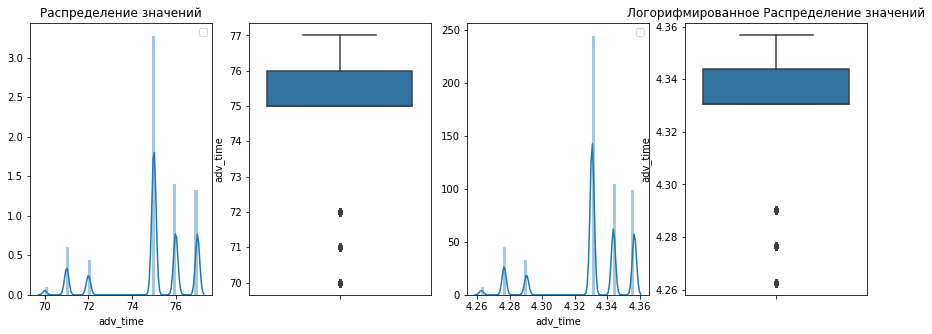

In [256]:
num_describer(df[df['Train']==0],'adv_time')

доля пропусков : 0.0 
 min : 36 
 25-й перцентиль: 47.0 
 медиана: 67.0 
 среднее: 129.051 
 max : 2126 
 75-й перцентиль: 122.0 
 IQR: 75.0 
 Границы выбросов: [-65.5, 234.5] 
 Доля выбросов: 0.1456



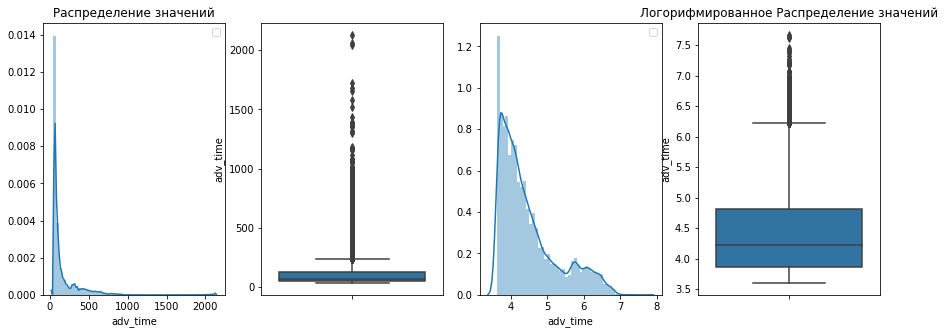

In [257]:
num_describer(df[df['Train']==1],'adv_time')

In [258]:
borders_of_outliers(df[df['Train']==1],['adv_time'], log = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,имя признака,левая граница,правая граница,выбросов слева,выбросов справа,доля выбросов слева,доля выбросов справа,левая граница с логарифмом,правая граница с логарифмом,выбросов слева с логарифмом,выбросов справа с логарифмом,доля выбросов слева с логарифмом,доля выбросов справа с логарифмом
0,adv_time,-65.5,234.5,0,10340,0,0.145642,2.45973,6.22366,0,3268,0,0.0460308


плохо релевантные выборки по этому параметру , но что поделать. Логарифмировпание сильно уменьшает число выбросов, потому логарифмируем этот признак.

In [259]:
df['adv_time']=np.log(df['adv_time'])

In [260]:
num_cols.append('adv_time')
df=df.drop(['start_date'],axis='columns')

## Вывод start_date
Сам признак удален, из него сделан признак - adv_time , отображающий сколько дней висит объявление до текущей даты. Исследование нового признака показало , что логарифмирование убирает выбросы и потому признак был логарифмирован.

#  анализ между переменными и целевой переменной price

In [261]:
df=df.drop(['reseller'],axis='columns')

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105682 entries, 0 to 106021
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             105682 non-null  object 
 1   brand                105682 non-null  object 
 2   color                105682 non-null  object 
 3   fuelType             105682 non-null  object 
 4   modelDate            105682 non-null  int64  
 5   numberOfDoors        105682 non-null  float64
 6   productionDate       105682 non-null  int64  
 7   vehicleTransmission  105682 non-null  object 
 8   engineDisplacement   105682 non-null  float64
 9   enginePower          105682 non-null  int64  
 10  mileage              105682 non-null  int64  
 11  Привод               105682 non-null  object 
 12  Руль                 105682 non-null  object 
 13  owners               105682 non-null  float64
 14  ПТС                  105682 non-null  object 
 15  price            

In [263]:
num_cols=['modelDate','productionDate','engineDisplacement','enginePower','mileage','log_diffDate','log_enginePower','annual_mileage','electro_eD','log_ownership','numberOfDoors','owners']
cat_cols=['bodyType','brand','color','fuelType','vehicleTransmission','Привод','model_name','ПТС','Руль']
bin_cols=['Guarantee','c_c_1','c_c_2','c_c_3','c_c_4','c_c_5','c_c_6','c_c_7','c_c_8','c_c_9','c_c_10','c_c_11','c_c_12','c_c_13','c_c_14']

In [264]:
target=['price']

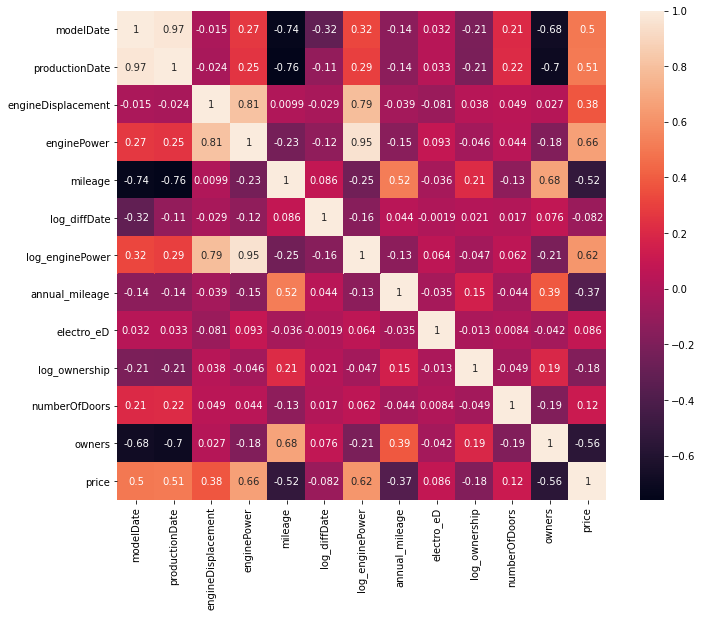

In [265]:
corrmat = df[df['Train'] == 1][num_cols+target].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=1, square=True,annot = True)

корреляция с целевой по убыванию:  
1.enginePower  
2.log_enginePower  
3.owners  
4.mileage  
5.productionDate  
6.modelDate  
7.engineDisplacement  
8.annual_mileage  
9.log_ownership  
10.numberOfDoors  
11.electro_eD  
12.log_diffDate  
  
  
Между собой сильно коррелируют modelDate-productionDate-mileage-owners,engineDisplacement-enginePower

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


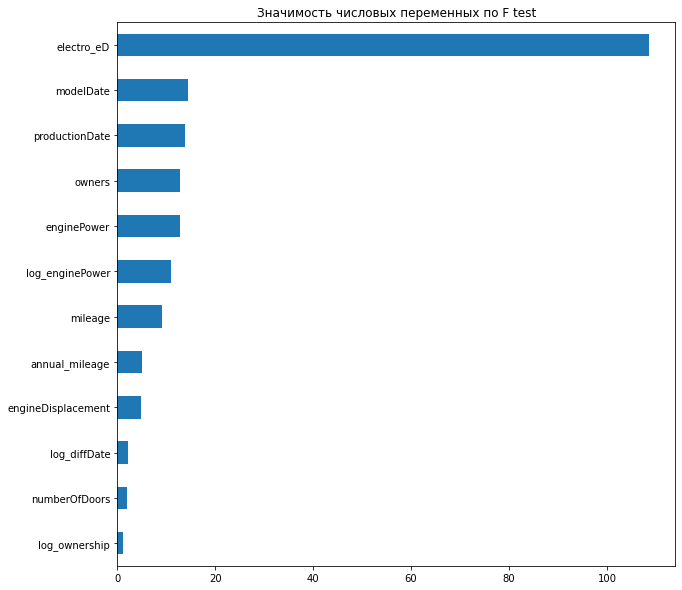

In [266]:
imp_num = pd.Series(f_classif(df[df['Train'] == 1][num_cols], df[df['Train'] == 1][target])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh',figsize=(10,10), title='Значимость числовых переменных по F test')

Данный тест показал иную значимость переменных. с ekectro_eD - согласен , признак мало где встречается, но как правило у его обладателей(электромобилейц)всегда высокая цена

In [267]:
df.shape

(105682, 40)

In [268]:
list_cols_bef_dumm = list(df.columns)
#прежде чем применять серьезные изменения - склонируем
df_t=df.copy()

df_t = pd.get_dummies(df_t, columns = cat_cols)

list_cols_aft_dumm = list(df_t.columns)
dumm_cols= list(set(list_cols_aft_dumm)-set(list_cols_bef_dumm ))

In [269]:
#создано 1165 новых колонок. с помощью теста стьюдента определим ненужные
df_t.shape

(105682, 1205)

In [270]:
def get_stat_dif(d_column, d_df):
    cols = d_df.loc[:, d_column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        ttest = ttest_ind(d_df.loc[d_df.loc[:, d_column] == comb[0], 'price'].dropna(),
                          d_df.loc[d_df.loc[:, d_column] == comb[1], 'price'].dropna()).pvalue
        if  ttest<= 0.05/len(combinations_all): # Учли поправку Бонферони
            return(d_column)
            break

stat_sign_diff_cols=[]
temp_df = df_t[(df_t['Train']==1)]
for col in bin_cols+dumm_cols:
    stat_sign_diff_cols.append(get_stat_dif(col,temp_df))
stat_sign_diff_cols = list(filter(None, stat_sign_diff_cols))

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 

In [271]:
print(len(stat_sign_diff_cols))
print(df_t.shape)

497
(105682, 1205)


In [272]:
not_stat_sign_diff_cols=list(set(bin_cols+dumm_cols) - set(stat_sign_diff_cols))

In [273]:
len(not_stat_sign_diff_cols)

692

In [274]:
for i in not_stat_sign_diff_cols:
    if 'model_name' not in i:
        print(i)

brand_jeep
bodyType_седан 2 дв.
color_розовый
bodyType_пикап одинарная кабина
fuelType_газ
bodyType_пикап полуторная кабина
bodyType_внедорожник открытый
bodyType_фастбек
fuelType_гибрид
bodyType_пикап двойная кабина
bodyType_кабриолет
bodyType_минивэн
c_c_7
brand_audi
brand_mini
bodyType_хэтчбек 4 дв.
brand_volvo


In [275]:
len(df.model_name.unique())

1081

в основном это попали разные названия авто)порядка для 680 моделей нет особых статистических различий. тому вино новые автомобили и ,как я думаю, обилие популярного среднего класса.  
я принял решение что удалю эти модели авто.  
типы кузовов удалять не буду, типы топлива удалять не буду. 3 марки тоже удалю если их немного.

In [276]:
for i in not_stat_sign_diff_cols:
    if 'model_name' in i:
        df_t=df_t.drop([i],axis='columns')

In [277]:
df_t=df_t.drop(['c_c_7'],axis='columns')
df_t=df_t.drop(['brand_mini'],axis='columns')
df_t=df_t.drop(['brand_jeep'],axis='columns')

In [278]:
df_t.shape

(105682, 527)

# Построение итоговой модели

In [279]:
df_test=df_t.query('Train == 0').drop(['Train','price'],axis=1)



df_train=df_t.query('Train == 1').drop(['Train'],axis=1)
df_train=df_train.drop(['sell_id'],axis='columns')

In [299]:
sell_id=df_test.sell_id.values

In [280]:
y = df_train.price.values            
X = df_train.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [281]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [282]:


model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')



# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")



Точность модели по метрике MAPE: 13.91%


In [283]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [284]:


model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')



# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 0.88%


In [285]:
from sklearn.model_selection import GridSearchCV

In [286]:

params = {'iterations'     : [3000,4000,5000],
          'learning_rate'  : [0.25, 0.5, 0.75,1]}

In [287]:
model = CatBoostRegressor(random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,)

grid = GridSearchCV(model, params,cv = 2, n_jobs=-1)

In [288]:
grid.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f8a05100890>,
             n_jobs=-1,
             param_grid={'iterations': [3000, 4000, 5000],
                         'learning_rate': [0.25, 0.5, 0.75, 1]})

In [289]:
print(grid.best_params_)

{'iterations': 3000, 'learning_rate': 0.25}


In [290]:
y = df_train.price.values            
X = df_train.drop(['price'], axis=1)

In [291]:
y

array([ 100000.,   90000.,   55000., ..., 1055000., 1280000., 1170000.])

In [292]:
y=np.log(y)
y

array([11.51292546, 11.40756495, 10.91508846, ..., 13.86905132,
       14.06237064, 13.97251431])

In [293]:
model = CatBoostRegressor(iterations = 3000,
                          learning_rate = 0.25,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X, y,
         #cat_features=cat_features_ids,
         eval_set=(X, y),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [294]:
df_test.head(2)

,modelDate,numberOfDoors,productionDate,engineDisplacement,enginePower,mileage,owners,sell_id,log_diffDate,log_enginePower,annual_mileage,Guarantee,electro_eD,log_ownership,c_c_1,c_c_2,c_c_3,c_c_4,c_c_5,c_c_6,c_c_8,c_c_9,c_c_10,c_c_11,c_c_12,c_c_13,c_c_14,adv_time,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_микровэн,bodyType_минивэн,bodyType_пикап двойная кабина,bodyType_пикап одинарная кабина,bodyType_пикап полуторная кабина,bodyType_родстер,bodyType_седан,bodyType_седан 2 дв.,bodyType_седан-хардтоп,bodyType_тарга,bodyType_универсал 5 дв.,bodyType_фастбек,bodyType_фургон,bodyType_хэтчбек 3 дв.,bodyType_хэтчбек 4 дв.,bodyType_хэтчбек 5 дв.,brand_audi,brand_bmw,brand_cadillac,brand_chery,brand_chevrolet,brand_chrysler,brand_citroen,brand_daewoo,brand_dodge,brand_ford,brand_geely,brand_great_wall,brand_honda,brand_hyundai,brand_infiniti,brand_jaguar,brand_kia,brand_land_rover,brand_lexus,brand_mazda,brand_mercedes,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_skoda,brand_ssang_yong,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo,color_бежевый,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,fuelType_бензин,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Привод_задний,Привод_передний,Привод_полный,model_name_100,model_name_107,model_name_190_SL,model_name_1ER,model_name_206,model_name_207,model_name_2ER,model_name_3,model_name_3008,model_name_300M,model_name_307,model_name_308,model_name_323,model_name_356,model_name_4007,model_name_406,model_name_407,model_name_408,model_name_460,model_name_5,model_name_5ER,model_name_6,model_name_626,model_name_6ER,model_name_740,model_name_7ER,model_name_80,model_name_850,model_name_8ER,model_name_911,model_name_940,model_name_960,model_name_A1,model_name_A3,model_name_A4,model_name_A6,model_name_A8,model_name_ACCENT,model_name_ACCORD,model_name_ACTYON,model_name_ACTYON_SPORT,model_name_ALLROAD,model_name_ALMERA,model_name_ALMERA_CLASSIC,model_name_ALPHARD,model_name_AMG_GLC_COUPE,model_name_AMG_GT,model_name_AMULET,model_name_ANTARA,model_name_ASTRA,model_name_ASX,model_name_AURIS,model_name_AVELLA,model_name_AVENSIS,model_name_AVEO,model_name_A_KLASSE,model_name_A_KLASSE_AMG,model_name_B9_TRIBECA,model_name_BALENO,model_name_BERLINGO,model_name_BLAZER,model_name_BONUS,model_name_BORA,model_name_BOXSTER,model_name_BT_50,model_name_B_KLASSE,model_name_C3,model_name_C30,model_name_C3_PICASSO,model_name_C4,model_name_C4_PICASSO,model_name_C5,model_name_CADDY,model_name_CALDINA,model_name_CALIBER,model_name_CAMRY,model_name_CAPTIVA,model_name_CARAVAN,model_name_CARAVELLE,model_name_CARENS,model_name_CARINA,model_name_CARINA_E,model_name_CARISMA,model_name_CAYENNE,model_name_CAYMAN_GT4,model_name_CEED,model_name_CEFIRO,model_name_CELICA,model_name_CERATO,model_name_CHALLENGER,model_name_CHARIOT,model_name_CHASER,model_name_CHEROKEE,model_name_CIVIC,model_name_CK,model_name_CLA_KLASSE,model_name_CLA_KLASSE_AMG,model_name_CLIO,model_name_CLIO_SYMBOL,model_name_CLK_KLASSE,model_name_CLS_KLASSE,model_name_CLS_KLASSE_AMG,model_name_COBALT,model_name_COLT,model_name_COMBO,model_name_COROLLA,model_name_CORONA,model_name_CORSA,model_name_CORVETTE,model_name_COUNTRYMAN,model_name_CRESTA,model_name_CRETA,model_name_CROWN,model_name_CRUZE,model_name_CR_V,model_name_CUBE,model_name_CX_7,model_name_C_CROSSER,model_name_C_ELYSEE,model_name_C_KLASSE_AMG,model_name_C_MAX,model_name_DEFENDER,model_name_DEMIO,model_name_DISCOVERY_SPORT,model_name_DS,model_name_DS4,model_name_DUSTER,mode

In [295]:
result_probs = model.predict(df_test)

In [296]:
result_probs

array([13.40549452, 13.77797397, 13.71724541, ..., 12.53301794,
       14.07074951, 13.99338967])

In [300]:
submission = pd.DataFrame({'sell_id': sell_id,
                              'price': result_probs})
submission.price = submission.price.apply(lambda x: np.round(math.exp(x),0))

In [ ]:
submission.to_csv('./submission.csv', index=False)
submission

# RandomForest

In [302]:
RF = RandomForestRegressor(random_state=RANDOM_SEED)

RF.fit(X_train, y_train)
test_predict = RF.predict(X_test)
print(f"Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")

Test MAPE: 0.891%


на стандартных параметрах выдан достаточно хороший результат.  
З.Ы. Я пробовал подбирать гридом параметры но это очень долго

# XGBRegressor

In [309]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators=1000, nthread = -1)
model_xgb.fit(X_train, y_train)
print('model fited')
test_predict = model_xgb.predict(X_test)
print(f"Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")


model fited
Test MAPE: 0.889%


# GradientBoostingRegressor

In [310]:
from sklearn.ensemble import GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=1000, random_state =42)
GBoost.fit(X_train, y_train)
test_predict = GBoost.predict(X_test)
print(f"Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")

Test MAPE: 1.020%


In [318]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
GBoost = GradientBoostingRegressor(n_estimators=1000, random_state =42)
model_xgb = xgb.XGBRegressor(n_estimators=1000, nthread = -1)
RF = RandomForestRegressor(random_state=RANDOM_SEED)

estimators = [
    ('rf', RF),
    ('gb',GBoost),
    ('xgb',model_xgb)
]

s_reg = StackingRegressor(estimators=estimators)
s_reg.fit(X_train, y_train)

test_predict = s_reg.predict(X_test)


print(f"Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")


Test MAPE: 0.854%


In [ ]:
Делать сабмит я не стал поскольку он на закрытых данных он показал несколько хуже результат, хоть и на тестовых данных результат был выше на 0,03%